In [1]:
# Import packages and libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from datetime import datetime


from sklearn.model_selection import PredefinedSplit


from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.tree import plot_tree

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import pickle
import math

import statsmodels.api as sm
from scipy import stats


In [2]:
pd.set_option('display.max_columns', None)

input_file_path='/kaggle/input/taxi-fareamount-prediction-eda/'

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Imports and data loading

In [3]:
#Load dataset (after cleaning)
df_clean=pd.read_csv(input_file_path+"taxi_trip_clean.csv")

In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21923 entries, 0 to 21922
Data columns (total 80 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   ID                                                      21923 non-null  int64  
 1   VendorID                                                21923 non-null  int64  
 2   tpep_pickup_datetime                                    21923 non-null  object 
 3   tpep_dropoff_datetime                                   21923 non-null  object 
 4   passenger_count                                         21923 non-null  int64  
 5   trip_distance                                           21923 non-null  float64
 6   RatecodeID                                              21923 non-null  int64  
 7   store_and_fwd_flag                                      21923 non-null  object 
 8   PULocationID                        

In [5]:
########################################
#convert string object to datetime
########################################
df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'])


#confirm after transform
df_clean[['tpep_pickup_datetime','tpep_dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21923 entries, 0 to 21922
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   21923 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  21923 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 342.7 KB


In [6]:
df_clean.head()

,ID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PU_hour,DO_hour,PU_day,DO_day,PU_month,DO_month,PU_weekday,DO_weekday,PU_year,PU_weeknum,PU_year_weeknum,PU_nextMonday,PU_date_hour,Borough_PU,Zone_PU,service_zone_PU,Borough_DO,Zone_DO,service_zone_DO,Date,NYC_All_Grades_All_Formulations_Retail_Gasoline_Prices,Year,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h),PU_DO_Borough,JFK,Newark,OutsideNYC,nighttime,rushhour,duration,duration_sec,avg_speed,fare_per_minute,fare_per_mile,holiday,PU_date,fare_amount_log,am_rush,daytime,pm_rush,PU_hour_class,rush_hour,PU_season
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,8,9,25,25,3,3,Saturday,Saturday,2017,12,2017-12,2017-03-27,2017-03-25-8,Manhattan,Garment District,Yellow Zone,Manhattan,TriBeCa/Civic Center,Yellow Zone,2017-03-27,2.476,2017,2017-03-25 08:00:00,10.6,73,6.0,8.5,0.0,0.0,0.0,0.04,1021.3,1015.1,100,0,79,100,7.4,13.8,309,298,13.3,Manhattan_Manhattan,False,False,False,0,False,14.067,844.0,14.246445,0.924171,3.892216,True,2017-03-25,2.564949,1,0,0,am_rush,0,spring
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,14,15,11,11,4,4,Tuesday,Tuesday,2017,15,2017-15,2017-04-17,2017-04-11-14,Manhattan,Penn Station/Madison Sq West,Yellow Zone,Manhattan,Central Park,Yellow Zone,2017-04-17,2.585,2017,2017-04-11 14:00:00,22.3,59,13.8,22.3,0.0,0.0,0.0,0.00,1018.9,1012.9,96,0,0,96,16.8,21.6,149,154,33.1,Manhattan_Manhattan,False,False,False,0,False,26.500,1590.0,4.075472,0.603774,8.888889,False,2017-04-11,2.772589,0,1,0,daytime,0,spring
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7,7,15,15,12,12,Friday,Friday,2017,50,2017-50,2017-12-18,2017-12-15-7,Manhattan,Yorkville East,Yellow Zone,Manhattan,Upper East Side North,Yellow Zone,2017-12-18,2.660,2017,2017-12-15 07:00:00,-5.7,51,-14.3,-9.6,0.0,0.0,0.0,0.05,1020.1,1013.5,87,0,75,86,2.9,4.3,263,265,6.8,Manhattan_Manhattan,False,False,False,0,False,7.200,432.0,8.333333,0.902778,6.500000,False,2017-12-15,1.871802,1,0,0,am_rush,1,winter
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,13,13,7,7,5,5,Sunday,Sunday,2017,18,2017-18,2017-05-08,2017-05-07-13,Brooklyn,Prospect-Lefferts Gardens,Boro Zone,Brooklyn,Fort Greene,Boro Zone,2017-05-08,2.561,2017,2017-05-07 13:00:00,13.3,52,3.6,9.1,0.0,0.0,0.0,0.00,1004.2,998.1,94,11,94,0,18.4,23.8,242,245,35.3,Brooklyn_Brooklyn,False,False,False,0,False,30.250,1815.0,7.338843,0.677686,5.540541,True,2017-05-07,3.020425,0,1,0,daytime,0,spring
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,23,23,15,15,4,4,Saturday,Saturday,2017,15,2017-15,2017-04-17,2017-04-15-23,Manhattan,Alphabet City,Yellow Zone,Brooklyn,Greenpoint,Boro Zone,2017-04-17,2.585,2017,2017-04-15 23:00:00,14.1,91,12.7,12.0,0.0,0.0,0.0,0.00,1018.9,1012.7,27,0,2,26,19.8,35.3,217,220,33.1,Manhattan_Brooklyn,False,False,False,1,False,16.717,1003.0,15.684945,0.987039,3.775744,True,2017-04-15,2.803360,0,0,0,nighttime,0,spring


### Define common variable

In [7]:
#define valid RatecodeID
RateCodeIDList=[1,2,3,4,5,6]

#define valid PULocationID and DOLocationID(exclude 264 Unknown)
LocationIDList=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105,
 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265]

#define locationid list without JFK airport, Newark airport, Unknown, Outside of NYC
LocationID_InsideNYC_Standard=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105,
 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
 254, 255, 256, 257, 258, 259, 260, 261, 262, 263]

#taxi zone LocationID of JFK airport
CONST_JFK_LocationID=132

#taxi zone LocationID of LaGuardia Airport
CONST_LaGuardia_LocationID=138

#taxi zone LocationID of Newark airport
CONST_Newark_LocationID=1

#taxi zone LocationID of Unknown
CONST_Unknown_LocationID=264


#Outside of NYC
CONST_Outside_NYC_LocationID=265


#Max work time
MAX_WORK_TIME_MINUTES=720

#Max speed 
MAX_SPEED=70

#rush hour surcharge for Standard Metered Fare
CONST_RUSH_HOUR_SURCHARGE_STANDARD=1

#rush hour surcharge for Manhattan<->JFK
CONST_RUSH_HOUR_SURCHARGE_JFK=4.5

#night time surcharge
CONST_NIGHT_TIME_SURCHARGE=0.5

#standard unit fare: $.50 per One-fifth of a mile 
#or $.50 per minute(60 seconds) traveling at less than 12 miles an hour
STANDARD_UNIT_FARE=0.5

#Standard Metered Fare initial charge
STANDARD_INITIAL_CHARGE=2.5

#define payment type that passenger could use
#1= Credit card 
#2= Cash 
Passenger_Payment=[1,2]




########################################
# Order
########################################
Weekday_Order = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday","Saturday"]


########################################
# Visualization
########################################
#Singal bar color
BAR_COLOR_BLUE='#1f77b4'

### Define common function

In [8]:
#https://www.statsmodels.org/dev/_modules/statsmodels/regression/linear_model.html#RegressionResults.aic
#####################################
# calculate maximized log likelihood
#####################################
def calculate_log_likelihood(n,resid):
    nobs = float(n)
    nobs2 = nobs / 2.0
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / n) - nobs2
    return llf

#####################################
# calculate AIC for regression
#####################################
def calculate_aic(n, resid, num_params):
    """
        n: Number of observations
        resid: residual
        num_params: Number of params
    """
    llf=calculate_log_likelihood(n,resid)
    aic=-2*llf+2*num_params
    return aic

#####################################
# calculate BIC for regression
#####################################
def calculate_bic(n, resid, num_params):
    """
        n: Number of observations
        resid: residual
        num_params: Number of params
    """
    llf=calculate_log_likelihood(n,resid)
    bic=-2*llf + np.log(n) * num_params
    return bic

#####################################
# calculate Adjusted R-Squared 
#####################################
def calculate_adjR2(r2,observations_num, predictor_num):
    adjusted_R2=1 - (1-r2)*(observations_num-1)/(observations_num-predictor_num)
    return adjusted_R2

In [9]:
df_clean.describe()

,ID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PU_hour,DO_hour,PU_day,DO_day,PU_month,DO_month,PU_year,PU_weeknum,NYC_All_Grades_All_Formulations_Retail_Gasoline_Prices,Year,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h),nighttime,duration,duration_sec,avg_speed,fare_per_minute,fare_per_mile,fare_amount_log,am_rush,daytime,pm_rush,rush_hour
count,2.192300e+04,21923.000000,21923,21923,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,2.192300e+04,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.0,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000,21923.000000
mean,5.677166e+07,1.562104,2017-06-29 09:58:01.511015680,2017-06-29 10:12:27.778543104,1.645258,2.913895,1.027049,160.917894,160.246225,1.321124,12.788291,0.332094,0.499019,1.820202,0.297332,3.000000e-01,16.036938,13.723487,13.753455,15.612462,15.616932,6.425216,6.425352,2017.0,26.099849,2.606419,2017.014870,12.528440,68.866898,6.476144,10.391643,0.122105,0.113493,0.006028,0.012432,1016.607545,1010.423026,59.740911,24.437486,31.381061,39.935821,14.295106,22.603877,201.670802,202.602564,27.259773,0.316243,14.437791,866.267527,11.290014,0.977853,6.140901,2.329067,0.153583,0.298636,0.231538,0.286275
min,1.212700e+04,1.000000,2017-01-01 00:08:25,2017-01-01 00:17:20,0.000000,0.010000,1.000000,4.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000e-01,3.300000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2017.0,1.000000,2.476000,2017.000000,-16.200000,14.000000,-25.500000,-21.600000,0.000000,0.000000,0.000000,0.000000,980.900000,975.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.400000,1.000000,1.000000,2.200000,0.000000,0.083000,5.000000,0.582996,0.052183,1.714474,0.916291,0.000000,0.000000,0.000000,0.000000
25%,2.861271e+07,1.000000,2017-03-30 09:03:20,2017-03-30 09:17:00,1.000000,1.000000,1.000000,113.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,3.000000e-01,8.750000,9.000000,9.000000,8.000000,8.000000,3.000000,3.000000,2017.0,13.000000,2.530000,2017.000000,4.800000,55.000000,-0.600000,0.500000,0.000000,0.000000,0.000000,0.000000,1012.100000,1006.000000,11.000000,0.000000,0.000000,0.000000,8.900000,15.000000,130.500000,129.000000,18.000000,0.000000,6.733000,404.000000,7.315649,0.767442,4.326923,1.871802,0.000000,0.000000,0.000000,0.000000
50%,5.677814e+07,2.000000,2017-06-23 15:12:43,2017-06-23 15:29:30,1.000000,1.630000,1.000000,161.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.360000,0.000000,3.000000e-01,11.800000,14.000000,14.000000,16.000000,16.000000,6.000000,6.000000,2017.0,25.000000,2.573000,2017.000000,13.100000,70.000000,7.700000,10.300000,0.000000,0.000000,0.000000,0.000000,1016.100000,1010.000000,79.000000,1.000000,10.000000,12.000000,13.300000,22.100000,222.000000,223.000000,25.600000,0.000000,11.200000,672.000000,9.869822,0.894040,5.504587,2.251292,0.000000,0.000000,0.000000,0.000000
75%,8.536476e+07,2.000000,2017-10-02 09:51:57.500000,2017-10-02 10:01:09.500000,2.000000,3.060000,1.000000,23

In [10]:
###########################################
#Transform Weekday Name columns
###########################################
df_clean['PU_weekday'] = pd.Categorical(df_clean['PU_weekday'], categories=Weekday_Order, ordered=True)
df_clean['PU_weekday'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 21923 entries, 0 to 21922
Series name: PU_weekday
Non-Null Count  Dtype   
--------------  -----   
21923 non-null  category
dtypes: category(1)
memory usage: 21.9 KB


In [11]:
#create PU_DO_LocationID
df_clean['PU_DO_LocationID']=df_clean['PULocationID'].astype(str)+'_'+df_clean['DOLocationID'].astype(str)
df_clean[['PULocationID','DOLocationID','PU_DO_LocationID']].head()

,PULocationID,DOLocationID,PU_DO_LocationID
0,100,231,100_231
1,186,43,186_43
2,262,236,262_236
3,188,97,188_97
4,4,112,4_112


### Build XGBoost Regression model

In [12]:
#'mean_distance', 'mean_duration', 'mean_avg_speed'
target_columns=['PU_DO_LocationID','trip_distance','duration','avg_speed',
                'fare_amount','RatecodeID', 'holiday',
                'PU_season','PU_weekday','PU_hour','PU_hour_class','rush_hour',
                #'am_rush','daytime','pm_rush','nighttime'
               ]
df_sample=df_clean[target_columns]

#encode holiday
holiday_map={
    True: 1,
    False: 0
}
df_sample['holiday']=df_sample['holiday'].map(holiday_map)

#define group by unit to compute 'mean_distance', 'mean_duration', 'mean_avg_speed'
#unit1: PU_DO_LocationID
df_sample['gpb_unit1']=df_sample['PU_DO_LocationID']
#unit2: PU_DO_LocationID + PU_hour
df_sample['gpb_unit2']=df_sample['PU_DO_LocationID']+'_'+df_sample['PU_hour'].astype(str)
#unit3: PU_DO_LocationID + PU_weekday + PU_hour
df_sample['gpb_unit3']=df_sample['PU_DO_LocationID']+'_'+df_sample['PU_weekday'].astype(str)+'_'+df_sample['PU_hour'].astype(str)
#unit4: PU_DO_LocationID + PU_hour_class
df_sample['gpb_unit4']=df_sample['PU_DO_LocationID']+'_'+df_sample['PU_hour_class'].astype(str)
#unit4: PU_DO_LocationID + holiday + PU_hour_class
df_sample['gpb_unit5']=df_sample['PU_DO_LocationID']+'_'+df_sample['holiday'].astype(str)+'_'+df_sample['PU_hour_class'].astype(str)

df_sample=df_sample.drop(columns=['PU_DO_LocationID'])
df_sample.head()

,trip_distance,duration,avg_speed,fare_amount,RatecodeID,holiday,PU_season,PU_weekday,PU_hour,PU_hour_class,rush_hour,gpb_unit1,gpb_unit2,gpb_unit3,gpb_unit4,gpb_unit5
0,3.34,14.067,14.246445,13.0,1,1,spring,Saturday,8,am_rush,0,100_231,100_231_8,100_231_Saturday_8,100_231_am_rush,100_231_1_am_rush
1,1.80,26.500,4.075472,16.0,1,0,spring,Tuesday,14,daytime,0,186_43,186_43_14,186_43_Tuesday_14,186_43_daytime,186_43_0_daytime
2,1.00,7.200,8.333333,6.5,1,0,winter,Friday,7,am_rush,1,262_236,262_236_7,262_236_Friday_7,262_236_am_rush,262_236_0_am_rush
3,3.70,30.250,7.338843,20.5,1,1,spring,Sunday,13,daytime,0,188_97,188_97_13,188_97_Sunday_13,188_97_daytime,188_97_1_daytime
4,4.37,16.717,15.684945,16.5,1,1,spring,Saturday,23,nighttime,0,4_112,4_112_23,4_112_Saturday_23,4_112_nighttime,4_112_1_nighttime


#### Dummy encoding

In [13]:
######################################################
#Dummy encoding
######################################################
# 1. Define list of cols to convert to string
df_dummy=df_sample.copy()
cols_to_str=['RatecodeID','PU_hour']

# 2. Convert each column to string
for col in cols_to_str:
    df_dummy[col]=df_dummy[col].astype(str)

#confirm after update
df_dummy.info()

#**************************#
#Confirm column names
#**************************#
#check object type and see if any object columns+'_' exists in other columns(e.g. RatecodeID and RatecodeID_XXXX NG)
#get columns which could be convert into dummy/indicator variables
trans_dummy_variables=list(df_dummy.select_dtypes(include=[object,'category']).columns)

#get columns which could not be convert into dummy/indicator variables
not_trans_dummy_variables=list(df_dummy.select_dtypes(exclude=[object,'category']).columns)

#after dummy encoding, their column name would be XXXX->XXXX_YYYY1,XXXX_YYYY2....
#get_fit_features will not work correctly if both XXXX and XXXX_?(Not columns after dummy encoding)(? means any word) exist
#e.g. RatecodeID and RatecodeID_good, RatecodeID_others will be NG
#RatecodeID and RatecodeIDA_good, Ratecode_BBB will be OK
if len(trans_dummy_variables)+len(not_trans_dummy_variables)!=len(df_dummy.columns):
    raise Exception("Data type incorrect, please check again")
if not (set(trans_dummy_variables).union(set(not_trans_dummy_variables))==set(df_dummy.columns)):
    raise Exception("Data type incorrect, please check again")
print(trans_dummy_variables)
dummy_prefix_sep='_dummy_'
duplicate_flg=False

for dummy_col in trans_dummy_variables:
    for not_trans_col in not_trans_dummy_variables:
        if (dummy_col+dummy_prefix_sep) in not_trans_col:
            duplicate_flg=True
if duplicate_flg==True:
    raise Exception("Dummy variable columns duplicated with others, please update column names")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21923 entries, 0 to 21922
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   trip_distance  21923 non-null  float64 
 1   duration       21923 non-null  float64 
 2   avg_speed      21923 non-null  float64 
 3   fare_amount    21923 non-null  float64 
 4   RatecodeID     21923 non-null  object  
 5   holiday        21923 non-null  int64   
 6   PU_season      21923 non-null  object  
 7   PU_weekday     21923 non-null  category
 8   PU_hour        21923 non-null  object  
 9   PU_hour_class  21923 non-null  object  
 10  rush_hour      21923 non-null  int64   
 11  gpb_unit1      21923 non-null  object  
 12  gpb_unit2      21923 non-null  object  
 13  gpb_unit3      21923 non-null  object  
 14  gpb_unit4      21923 non-null  object  
 15  gpb_unit5      21923 non-null  object  
dtypes: category(1), float64(4), int64(2), object(9)
memory usage: 2.5+ MB
['Rate

In [14]:
# Convert categoricals to binary
df_dummy=pd.get_dummies(df_dummy,columns=['RatecodeID','PU_hour','PU_weekday','PU_season','PU_hour_class'], prefix_sep=dummy_prefix_sep, dtype=bool, prefix=None)
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21923 entries, 0 to 21922
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   trip_distance                  21923 non-null  float64
 1   duration                       21923 non-null  float64
 2   avg_speed                      21923 non-null  float64
 3   fare_amount                    21923 non-null  float64
 4   holiday                        21923 non-null  int64  
 5   rush_hour                      21923 non-null  int64  
 6   gpb_unit1                      21923 non-null  object 
 7   gpb_unit2                      21923 non-null  object 
 8   gpb_unit3                      21923 non-null  object 
 9   gpb_unit4                      21923 non-null  object 
 10  gpb_unit5                      21923 non-null  object 
 11  RatecodeID_dummy_1             21923 non-null  bool   
 12  RatecodeID_dummy_2             21923 non-null 

#### Label encoding

In [15]:
######################################################
#Label encoding
######################################################
df_label=df_sample.copy()

#******************************#
#label encoding
#******************************#
#encoding PU_season
season_map={
    "spring": 0,
    "summer": 1,
    "autumn": 2,
    "winter": 3,
}
hour_class_map={
    'nighttime':0,
    'am_rush':1,
    'pm_rush':2,
    'daytime':3,
}

df_label['PU_season']=df_label['PU_season'].map(season_map)
df_label['PU_hour_class']=df_label['PU_hour_class'].map(hour_class_map)
df_label['PU_weekday']=df_label['PU_weekday'].cat.codes
#confirm after update
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21923 entries, 0 to 21922
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trip_distance  21923 non-null  float64
 1   duration       21923 non-null  float64
 2   avg_speed      21923 non-null  float64
 3   fare_amount    21923 non-null  float64
 4   RatecodeID     21923 non-null  int64  
 5   holiday        21923 non-null  int64  
 6   PU_season      21923 non-null  int64  
 7   PU_weekday     21923 non-null  int8   
 8   PU_hour        21923 non-null  int64  
 9   PU_hour_class  21923 non-null  int64  
 10  rush_hour      21923 non-null  int64  
 11  gpb_unit1      21923 non-null  object 
 12  gpb_unit2      21923 non-null  object 
 13  gpb_unit3      21923 non-null  object 
 14  gpb_unit4      21923 non-null  object 
 15  gpb_unit5      21923 non-null  object 
dtypes: float64(4), int64(6), int8(1), object(5)
memory usage: 2.5+ MB


### Create the training, validation and testing data

In [16]:
RANDOM_STATE=0

################################################
#Use dummy encoding dataset
################################################
y_dummy = df_dummy['fare_amount']
X_dummy = df_dummy.copy()
X_dummy = X_dummy.drop(columns=['fare_amount'], axis = 1)

X_dummy_train_val, X_dummy_test, y_dummy_train_val, y_dummy_test = train_test_split(X_dummy, y_dummy, 
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)

# Split train into train and validation sets
X_dummy_train, X_dummy_val, y_dummy_train, y_dummy_val = train_test_split(X_dummy_train_val, y_dummy_train_val, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE)


################################################
#Use Label encoding dataset
################################################
y_label = df_label['fare_amount']
X_label = df_label.copy()
X_label = X_label.drop(columns=['fare_amount'], axis = 1)

X_label_train_val, X_label_test, y_label_train_val, y_label_test = train_test_split(X_label, y_label, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE)

# Split train into train and validation sets
X_label_train, X_label_val, y_label_train, y_label_val = train_test_split(X_label_train_val, y_label_train_val, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE)

#### Create `mean_distance` column


In [17]:
################################################
#Use dummy encoding dataset
################################################
dummy_gpb_unit1=X_dummy_train.groupby(['gpb_unit1'])[['trip_distance']].mean()
dummy_gpb_unit2=X_dummy_train.groupby(['gpb_unit2'])[['trip_distance']].mean()
dummy_gpb_unit3=X_dummy_train.groupby(['gpb_unit3'])[['trip_distance']].mean()
dummy_gpb_unit4=X_dummy_train.groupby(['gpb_unit4'])[['trip_distance']].mean()
dummy_gpb_unit5=X_dummy_train.groupby(['gpb_unit5'])[['trip_distance']].mean()
################################################
#Use Label encoding dataset
################################################
label_gpb_unit1=X_label_train.groupby(['gpb_unit1'])[['trip_distance']].mean()
label_gpb_unit2=X_label_train.groupby(['gpb_unit2'])[['trip_distance']].mean()
label_gpb_unit3=X_label_train.groupby(['gpb_unit3'])[['trip_distance']].mean()
label_gpb_unit4=X_label_train.groupby(['gpb_unit4'])[['trip_distance']].mean()
label_gpb_unit5=X_label_train.groupby(['gpb_unit5'])[['trip_distance']].mean()

In [18]:
################################################
#Use dummy encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
dummy_gpb_unit1_dict=dummy_gpb_unit1.to_dict()
dummy_gpb_unit2_dict=dummy_gpb_unit2.to_dict()
dummy_gpb_unit3_dict=dummy_gpb_unit3.to_dict()
dummy_gpb_unit4_dict=dummy_gpb_unit4.to_dict()
dummy_gpb_unit5_dict=dummy_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_gpb_unit1_dict=dummy_gpb_unit1_dict.get('trip_distance')
dummy_gpb_unit2_dict=dummy_gpb_unit2_dict.get('trip_distance')
dummy_gpb_unit3_dict=dummy_gpb_unit3_dict.get('trip_distance')
dummy_gpb_unit4_dict=dummy_gpb_unit4_dict.get('trip_distance')
dummy_gpb_unit5_dict=dummy_gpb_unit5_dict.get('trip_distance')

################################################
#Use Label encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
label_gpb_unit1_dict=label_gpb_unit1.to_dict()
label_gpb_unit2_dict=label_gpb_unit2.to_dict()
label_gpb_unit3_dict=label_gpb_unit3.to_dict()
label_gpb_unit4_dict=label_gpb_unit4.to_dict()
label_gpb_unit5_dict=label_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_gpb_unit1_dict=label_gpb_unit1_dict.get('trip_distance')
label_gpb_unit2_dict=label_gpb_unit2_dict.get('trip_distance')
label_gpb_unit3_dict=label_gpb_unit3_dict.get('trip_distance')
label_gpb_unit4_dict=label_gpb_unit4_dict.get('trip_distance')
label_gpb_unit5_dict=label_gpb_unit5_dict.get('trip_distance')

In [19]:
################################################
#Use dummy encoding dataset
#training set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_dummy_train['mean_distance_unit1']=X_dummy_train['gpb_unit1']
X_dummy_train['mean_distance_unit2']=X_dummy_train['gpb_unit2']
X_dummy_train['mean_distance_unit3']=X_dummy_train['gpb_unit3']
X_dummy_train['mean_distance_unit4']=X_dummy_train['gpb_unit4']
X_dummy_train['mean_distance_unit5']=X_dummy_train['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_dummy_train['mean_distance_unit1']=X_dummy_train['mean_distance_unit1'].map(dummy_gpb_unit1_dict)
X_dummy_train['mean_distance_unit2']=X_dummy_train['mean_distance_unit2'].map(dummy_gpb_unit2_dict)
X_dummy_train['mean_distance_unit3']=X_dummy_train['mean_distance_unit3'].map(dummy_gpb_unit3_dict)
X_dummy_train['mean_distance_unit4']=X_dummy_train['mean_distance_unit4'].map(dummy_gpb_unit4_dict)
X_dummy_train['mean_distance_unit5']=X_dummy_train['mean_distance_unit5'].map(dummy_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#training set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_label_train['mean_distance_unit1']=X_label_train['gpb_unit1']
X_label_train['mean_distance_unit2']=X_label_train['gpb_unit2']
X_label_train['mean_distance_unit3']=X_label_train['gpb_unit3']
X_label_train['mean_distance_unit4']=X_label_train['gpb_unit4']
X_label_train['mean_distance_unit5']=X_label_train['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_label_train['mean_distance_unit1']=X_label_train['mean_distance_unit1'].map(label_gpb_unit1_dict)
X_label_train['mean_distance_unit2']=X_label_train['mean_distance_unit2'].map(label_gpb_unit2_dict)
X_label_train['mean_distance_unit3']=X_label_train['mean_distance_unit3'].map(label_gpb_unit3_dict)
X_label_train['mean_distance_unit4']=X_label_train['mean_distance_unit4'].map(label_gpb_unit4_dict)
X_label_train['mean_distance_unit5']=X_label_train['mean_distance_unit5'].map(label_gpb_unit5_dict)


In [20]:
################################################
#Use dummy encoding dataset
#training set
################################################
# Confirm that it worked
display(X_dummy_train[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_dummy_train[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

################################################
#Use label encoding dataset
#training set
################################################
# Confirm that it worked
display(X_label_train[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_label_train[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  13153 non-null  float64
 1   mean_distance_unit2  13153 non-null  float64
 2   mean_distance_unit3  13153 non-null  float64
 3   mean_distance_unit4  13153 non-null  float64
 4   mean_distance_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
6347,2.075000,2.0000,2.00,2.075000,2.000000
8876,1.053117,0.9625,0.88,0.963947,1.038000
279,1.048000,1.1600,1.16,1.282500,1.110000
18331,1.944000,2.1000,2.10,2.100000,2.100000
6326,1.124000,1.3100,2.13,1.231667,1.231667


<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  13153 non-null  float64
 1   mean_distance_unit2  13153 non-null  float64
 2   mean_distance_unit3  13153 non-null  float64
 3   mean_distance_unit4  13153 non-null  float64
 4   mean_distance_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
6347,2.075000,2.0000,2.00,2.075000,2.000000
8876,1.053117,0.9625,0.88,0.963947,1.038000
279,1.048000,1.1600,1.16,1.282500,1.110000
18331,1.944000,2.1000,2.10,2.100000,2.100000
6326,1.124000,1.3100,2.13,1.231667,1.231667


In [21]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_dummy_val['mean_distance_unit1']=X_dummy_val['gpb_unit1']
X_dummy_val['mean_distance_unit2']=X_dummy_val['gpb_unit2']
X_dummy_val['mean_distance_unit3']=X_dummy_val['gpb_unit3']
X_dummy_val['mean_distance_unit4']=X_dummy_val['gpb_unit4']
X_dummy_val['mean_distance_unit5']=X_dummy_val['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_dummy_val['mean_distance_unit1']=X_dummy_val['mean_distance_unit1'].map(dummy_gpb_unit1_dict)
X_dummy_val['mean_distance_unit2']=X_dummy_val['mean_distance_unit2'].map(dummy_gpb_unit2_dict)
X_dummy_val['mean_distance_unit3']=X_dummy_val['mean_distance_unit3'].map(dummy_gpb_unit3_dict)
X_dummy_val['mean_distance_unit4']=X_dummy_val['mean_distance_unit4'].map(dummy_gpb_unit4_dict)
X_dummy_val['mean_distance_unit5']=X_dummy_val['mean_distance_unit5'].map(dummy_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#validation set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_label_val['mean_distance_unit1']=X_label_val['gpb_unit1']
X_label_val['mean_distance_unit2']=X_label_val['gpb_unit2']
X_label_val['mean_distance_unit3']=X_label_val['gpb_unit3']
X_label_val['mean_distance_unit4']=X_label_val['gpb_unit4']
X_label_val['mean_distance_unit5']=X_label_val['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_label_val['mean_distance_unit1']=X_label_val['mean_distance_unit1'].map(label_gpb_unit1_dict)
X_label_val['mean_distance_unit2']=X_label_val['mean_distance_unit2'].map(label_gpb_unit2_dict)
X_label_val['mean_distance_unit3']=X_label_val['mean_distance_unit3'].map(label_gpb_unit3_dict)
X_label_val['mean_distance_unit4']=X_label_val['mean_distance_unit4'].map(label_gpb_unit4_dict)
X_label_val['mean_distance_unit5']=X_label_val['mean_distance_unit5'].map(label_gpb_unit5_dict)


In [22]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_val.shape[0]}')
display(X_dummy_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_dummy_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

################################################
#Use label encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_val.shape[0]}')
display(X_label_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_label_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  2925 non-null   float64
 1   mean_distance_unit2  1206 non-null   float64
 2   mean_distance_unit3  259 non-null    float64
 3   mean_distance_unit4  2376 non-null   float64
 4   mean_distance_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,1.4220,NaN,NaN,1.620000,1.833333
6920,11.0255,11.216667,NaN,11.074444,12.616667
9383,3.6000,NaN,NaN,NaN,NaN


Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  2925 non-null   float64
 1   mean_distance_unit2  1206 non-null   float64
 2   mean_distance_unit3  259 non-null    float64
 3   mean_distance_unit4  2376 non-null   float64
 4   mean_distance_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,1.4220,NaN,NaN,1.620000,1.833333
6920,11.0255,11.216667,NaN,11.074444,12.616667
9383,3.6000,NaN,NaN,NaN,NaN


#### Create `mean_duration` column

In [23]:
################################################
#Use dummy encoding dataset
################################################
dummy_duration_gpb_unit1=X_dummy_train.groupby(['gpb_unit1'])[['duration']].mean()
dummy_duration_gpb_unit2=X_dummy_train.groupby(['gpb_unit2'])[['duration']].mean()
dummy_duration_gpb_unit3=X_dummy_train.groupby(['gpb_unit3'])[['duration']].mean()
dummy_duration_gpb_unit4=X_dummy_train.groupby(['gpb_unit4'])[['duration']].mean()
dummy_duration_gpb_unit5=X_dummy_train.groupby(['gpb_unit5'])[['duration']].mean()
################################################
#Use Label encoding dataset
################################################
label_duration_gpb_unit1=X_label_train.groupby(['gpb_unit1'])[['duration']].mean()
label_duration_gpb_unit2=X_label_train.groupby(['gpb_unit2'])[['duration']].mean()
label_duration_gpb_unit3=X_label_train.groupby(['gpb_unit3'])[['duration']].mean()
label_duration_gpb_unit4=X_label_train.groupby(['gpb_unit4'])[['duration']].mean()
label_duration_gpb_unit5=X_label_train.groupby(['gpb_unit5'])[['duration']].mean()

In [24]:
################################################
#Use dummy encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
dummy_duration_gpb_unit1_dict=dummy_duration_gpb_unit1.to_dict()
dummy_duration_gpb_unit2_dict=dummy_duration_gpb_unit2.to_dict()
dummy_duration_gpb_unit3_dict=dummy_duration_gpb_unit3.to_dict()
dummy_duration_gpb_unit4_dict=dummy_duration_gpb_unit4.to_dict()
dummy_duration_gpb_unit5_dict=dummy_duration_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_duration_gpb_unit1_dict=dummy_duration_gpb_unit1_dict.get('duration')
dummy_duration_gpb_unit2_dict=dummy_duration_gpb_unit2_dict.get('duration')
dummy_duration_gpb_unit3_dict=dummy_duration_gpb_unit3_dict.get('duration')
dummy_duration_gpb_unit4_dict=dummy_duration_gpb_unit4_dict.get('duration')
dummy_duration_gpb_unit5_dict=dummy_duration_gpb_unit5_dict.get('duration')

################################################
#Use Label encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
label_duration_gpb_unit1_dict=label_duration_gpb_unit1.to_dict()
label_duration_gpb_unit2_dict=label_duration_gpb_unit2.to_dict()
label_duration_gpb_unit3_dict=label_duration_gpb_unit3.to_dict()
label_duration_gpb_unit4_dict=label_duration_gpb_unit4.to_dict()
label_duration_gpb_unit5_dict=label_duration_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_duration_gpb_unit1_dict=label_duration_gpb_unit1_dict.get('duration')
label_duration_gpb_unit2_dict=label_duration_gpb_unit2_dict.get('duration')
label_duration_gpb_unit3_dict=label_duration_gpb_unit3_dict.get('duration')
label_duration_gpb_unit4_dict=label_duration_gpb_unit4_dict.get('duration')
label_duration_gpb_unit5_dict=label_duration_gpb_unit5_dict.get('duration')

In [25]:
################################################
#Use dummy encoding dataset
#training set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_dummy_train['mean_duration_unit1']=X_dummy_train['gpb_unit1']
X_dummy_train['mean_duration_unit2']=X_dummy_train['gpb_unit2']
X_dummy_train['mean_duration_unit3']=X_dummy_train['gpb_unit3']
X_dummy_train['mean_duration_unit4']=X_dummy_train['gpb_unit4']
X_dummy_train['mean_duration_unit5']=X_dummy_train['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_dummy_train['mean_duration_unit1']=X_dummy_train['mean_duration_unit1'].map(dummy_duration_gpb_unit1_dict)
X_dummy_train['mean_duration_unit2']=X_dummy_train['mean_duration_unit2'].map(dummy_duration_gpb_unit2_dict)
X_dummy_train['mean_duration_unit3']=X_dummy_train['mean_duration_unit3'].map(dummy_duration_gpb_unit3_dict)
X_dummy_train['mean_duration_unit4']=X_dummy_train['mean_duration_unit4'].map(dummy_duration_gpb_unit4_dict)
X_dummy_train['mean_duration_unit5']=X_dummy_train['mean_duration_unit5'].map(dummy_duration_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#training set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_label_train['mean_duration_unit1']=X_label_train['gpb_unit1']
X_label_train['mean_duration_unit2']=X_label_train['gpb_unit2']
X_label_train['mean_duration_unit3']=X_label_train['gpb_unit3']
X_label_train['mean_duration_unit4']=X_label_train['gpb_unit4']
X_label_train['mean_duration_unit5']=X_label_train['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_label_train['mean_duration_unit1']=X_label_train['mean_duration_unit1'].map(label_duration_gpb_unit1_dict)
X_label_train['mean_duration_unit2']=X_label_train['mean_duration_unit2'].map(label_duration_gpb_unit2_dict)
X_label_train['mean_duration_unit3']=X_label_train['mean_duration_unit3'].map(label_duration_gpb_unit3_dict)
X_label_train['mean_duration_unit4']=X_label_train['mean_duration_unit4'].map(label_duration_gpb_unit4_dict)
X_label_train['mean_duration_unit5']=X_label_train['mean_duration_unit5'].map(label_duration_gpb_unit5_dict)


In [26]:
################################################
#Use dummy encoding dataset
#training set
################################################
# Confirm that it worked
display(X_dummy_train[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_dummy_train[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

################################################
#Use label encoding dataset
#training set
################################################
# Confirm that it worked
display(X_label_train[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_label_train[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  13153 non-null  float64
 1   mean_duration_unit2  13153 non-null  float64
 2   mean_duration_unit3  13153 non-null  float64
 3   mean_duration_unit4  13153 non-null  float64
 4   mean_duration_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
6347,11.141500,10.900000,10.900,11.141500,10.900000
8876,6.871662,7.900000,5.275,7.542526,4.738300
279,9.502450,8.550000,8.550,8.408250,8.744333
18331,11.023400,12.367000,12.367,12.367000,12.367000
6326,8.751489,10.594667,12.417,7.883500,7.883500


<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  13153 non-null  float64
 1   mean_duration_unit2  13153 non-null  float64
 2   mean_duration_unit3  13153 non-null  float64
 3   mean_duration_unit4  13153 non-null  float64
 4   mean_duration_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
6347,11.141500,10.900000,10.900,11.141500,10.900000
8876,6.871662,7.900000,5.275,7.542526,4.738300
279,9.502450,8.550000,8.550,8.408250,8.744333
18331,11.023400,12.367000,12.367,12.367000,12.367000
6326,8.751489,10.594667,12.417,7.883500,7.883500


In [27]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_dummy_val['mean_duration_unit1']=X_dummy_val['gpb_unit1']
X_dummy_val['mean_duration_unit2']=X_dummy_val['gpb_unit2']
X_dummy_val['mean_duration_unit3']=X_dummy_val['gpb_unit3']
X_dummy_val['mean_duration_unit4']=X_dummy_val['gpb_unit4']
X_dummy_val['mean_duration_unit5']=X_dummy_val['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_dummy_val['mean_duration_unit1']=X_dummy_val['mean_duration_unit1'].map(dummy_duration_gpb_unit1_dict)
X_dummy_val['mean_duration_unit2']=X_dummy_val['mean_duration_unit2'].map(dummy_duration_gpb_unit2_dict)
X_dummy_val['mean_duration_unit3']=X_dummy_val['mean_duration_unit3'].map(dummy_duration_gpb_unit3_dict)
X_dummy_val['mean_duration_unit4']=X_dummy_val['mean_duration_unit4'].map(dummy_duration_gpb_unit4_dict)
X_dummy_val['mean_duration_unit5']=X_dummy_val['mean_duration_unit5'].map(dummy_duration_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#validation set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_label_val['mean_duration_unit1']=X_label_val['gpb_unit1']
X_label_val['mean_duration_unit2']=X_label_val['gpb_unit2']
X_label_val['mean_duration_unit3']=X_label_val['gpb_unit3']
X_label_val['mean_duration_unit4']=X_label_val['gpb_unit4']
X_label_val['mean_duration_unit5']=X_label_val['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_label_val['mean_duration_unit1']=X_label_val['mean_duration_unit1'].map(label_duration_gpb_unit1_dict)
X_label_val['mean_duration_unit2']=X_label_val['mean_duration_unit2'].map(label_duration_gpb_unit2_dict)
X_label_val['mean_duration_unit3']=X_label_val['mean_duration_unit3'].map(label_duration_gpb_unit3_dict)
X_label_val['mean_duration_unit4']=X_label_val['mean_duration_unit4'].map(label_duration_gpb_unit4_dict)
X_label_val['mean_duration_unit5']=X_label_val['mean_duration_unit5'].map(label_duration_gpb_unit5_dict)


In [28]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_val.shape[0]}')
display(X_dummy_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_dummy_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

################################################
#Use label encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_val.shape[0]}')
display(X_label_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_label_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  2925 non-null   float64
 1   mean_duration_unit2  1206 non-null   float64
 2   mean_duration_unit3  259 non-null    float64
 3   mean_duration_unit4  2376 non-null   float64
 4   mean_duration_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,10.61335,NaN,NaN,13.220000,17.100000
6920,44.79745,59.183333,NaN,48.914889,50.044667
9383,29.70000,NaN,NaN,NaN,NaN


Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  2925 non-null   float64
 1   mean_duration_unit2  1206 non-null   float64
 2   mean_duration_unit3  259 non-null    float64
 3   mean_duration_unit4  2376 non-null   float64
 4   mean_duration_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,10.61335,NaN,NaN,13.220000,17.100000
6920,44.79745,59.183333,NaN,48.914889,50.044667
9383,29.70000,NaN,NaN,NaN,NaN


#### Create `mean_speed` column

In [29]:
################################################
#Use dummy encoding dataset
################################################
dummy_speed_gpb_unit1=X_dummy_train.groupby(['gpb_unit1'])[['avg_speed']].mean()
dummy_speed_gpb_unit2=X_dummy_train.groupby(['gpb_unit2'])[['avg_speed']].mean()
dummy_speed_gpb_unit3=X_dummy_train.groupby(['gpb_unit3'])[['avg_speed']].mean()
dummy_speed_gpb_unit4=X_dummy_train.groupby(['gpb_unit4'])[['avg_speed']].mean()
dummy_speed_gpb_unit5=X_dummy_train.groupby(['gpb_unit5'])[['avg_speed']].mean()
################################################
#Use Label encoding dataset
################################################
label_speed_gpb_unit1=X_label_train.groupby(['gpb_unit1'])[['avg_speed']].mean()
label_speed_gpb_unit2=X_label_train.groupby(['gpb_unit2'])[['avg_speed']].mean()
label_speed_gpb_unit3=X_label_train.groupby(['gpb_unit3'])[['avg_speed']].mean()
label_speed_gpb_unit4=X_label_train.groupby(['gpb_unit4'])[['avg_speed']].mean()
label_speed_gpb_unit5=X_label_train.groupby(['gpb_unit5'])[['avg_speed']].mean()

In [30]:
################################################
#Use dummy encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
dummy_speed_gpb_unit1_dict=dummy_speed_gpb_unit1.to_dict()
dummy_speed_gpb_unit2_dict=dummy_speed_gpb_unit2.to_dict()
dummy_speed_gpb_unit3_dict=dummy_speed_gpb_unit3.to_dict()
dummy_speed_gpb_unit4_dict=dummy_speed_gpb_unit4.to_dict()
dummy_speed_gpb_unit5_dict=dummy_speed_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_speed_gpb_unit1_dict=dummy_speed_gpb_unit1_dict.get('avg_speed')
dummy_speed_gpb_unit2_dict=dummy_speed_gpb_unit2_dict.get('avg_speed')
dummy_speed_gpb_unit3_dict=dummy_speed_gpb_unit3_dict.get('avg_speed')
dummy_speed_gpb_unit4_dict=dummy_speed_gpb_unit4_dict.get('avg_speed')
dummy_speed_gpb_unit5_dict=dummy_speed_gpb_unit5_dict.get('avg_speed')

################################################
#Use Label encoding dataset
################################################
# 1. Convert `grouped` to a dictionary
label_speed_gpb_unit1_dict=label_speed_gpb_unit1.to_dict()
label_speed_gpb_unit2_dict=label_speed_gpb_unit2.to_dict()
label_speed_gpb_unit3_dict=label_speed_gpb_unit3.to_dict()
label_speed_gpb_unit4_dict=label_speed_gpb_unit4.to_dict()
label_speed_gpb_unit5_dict=label_speed_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_speed_gpb_unit1_dict=label_speed_gpb_unit1_dict.get('avg_speed')
label_speed_gpb_unit2_dict=label_speed_gpb_unit2_dict.get('avg_speed')
label_speed_gpb_unit3_dict=label_speed_gpb_unit3_dict.get('avg_speed')
label_speed_gpb_unit4_dict=label_speed_gpb_unit4_dict.get('avg_speed')
label_speed_gpb_unit5_dict=label_speed_gpb_unit5_dict.get('avg_speed')

In [31]:
################################################
#Use dummy encoding dataset
#training set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_dummy_train['mean_speed_unit1']=X_dummy_train['gpb_unit1']
X_dummy_train['mean_speed_unit2']=X_dummy_train['gpb_unit2']
X_dummy_train['mean_speed_unit3']=X_dummy_train['gpb_unit3']
X_dummy_train['mean_speed_unit4']=X_dummy_train['gpb_unit4']
X_dummy_train['mean_speed_unit5']=X_dummy_train['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_dummy_train['mean_speed_unit1']=X_dummy_train['mean_speed_unit1'].map(dummy_speed_gpb_unit1_dict)
X_dummy_train['mean_speed_unit2']=X_dummy_train['mean_speed_unit2'].map(dummy_speed_gpb_unit2_dict)
X_dummy_train['mean_speed_unit3']=X_dummy_train['mean_speed_unit3'].map(dummy_speed_gpb_unit3_dict)
X_dummy_train['mean_speed_unit4']=X_dummy_train['mean_speed_unit4'].map(dummy_speed_gpb_unit4_dict)
X_dummy_train['mean_speed_unit5']=X_dummy_train['mean_speed_unit5'].map(dummy_speed_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#training set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_label_train['mean_speed_unit1']=X_label_train['gpb_unit1']
X_label_train['mean_speed_unit2']=X_label_train['gpb_unit2']
X_label_train['mean_speed_unit3']=X_label_train['gpb_unit3']
X_label_train['mean_speed_unit4']=X_label_train['gpb_unit4']
X_label_train['mean_speed_unit5']=X_label_train['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_label_train['mean_speed_unit1']=X_label_train['mean_speed_unit1'].map(label_speed_gpb_unit1_dict)
X_label_train['mean_speed_unit2']=X_label_train['mean_speed_unit2'].map(label_speed_gpb_unit2_dict)
X_label_train['mean_speed_unit3']=X_label_train['mean_speed_unit3'].map(label_speed_gpb_unit3_dict)
X_label_train['mean_speed_unit4']=X_label_train['mean_speed_unit4'].map(label_speed_gpb_unit4_dict)
X_label_train['mean_speed_unit5']=X_label_train['mean_speed_unit5'].map(label_speed_gpb_unit5_dict)



In [32]:
################################################
#Use dummy encoding dataset
#training set
################################################
# Confirm that it worked
display(X_dummy_train[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_dummy_train[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

################################################
#Use label encoding dataset
#training set
################################################
# Confirm that it worked
display(X_label_train[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_label_train[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())


<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  13153 non-null  float64
 1   mean_speed_unit2  13153 non-null  float64
 2   mean_speed_unit3  13153 non-null  float64
 3   mean_speed_unit4  13153 non-null  float64
 4   mean_speed_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
6347,11.170766,11.009174,11.009174,11.170766,11.009174
8876,10.677032,8.028721,11.532715,8.867039,14.530911
279,8.278451,8.140351,8.140351,10.557092,9.211258
18331,11.381738,10.188679,10.188679,10.188679,10.188679
6326,8.589126,7.950708,10.292617,10.414092,10.414092


<class 'pandas.core.frame.DataFrame'>
Index: 13153 entries, 6347 to 3214
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  13153 non-null  float64
 1   mean_speed_unit2  13153 non-null  float64
 2   mean_speed_unit3  13153 non-null  float64
 3   mean_speed_unit4  13153 non-null  float64
 4   mean_speed_unit5  13153 non-null  float64
dtypes: float64(5)
memory usage: 616.5 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
6347,11.170766,11.009174,11.009174,11.170766,11.009174
8876,10.677032,8.028721,11.532715,8.867039,14.530911
279,8.278451,8.140351,8.140351,10.557092,9.211258
18331,11.381738,10.188679,10.188679,10.188679,10.188679
6326,8.589126,7.950708,10.292617,10.414092,10.414092


In [33]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_dummy_val['mean_speed_unit1']=X_dummy_val['gpb_unit1']
X_dummy_val['mean_speed_unit2']=X_dummy_val['gpb_unit2']
X_dummy_val['mean_speed_unit3']=X_dummy_val['gpb_unit3']
X_dummy_val['mean_speed_unit4']=X_dummy_val['gpb_unit4']
X_dummy_val['mean_speed_unit5']=X_dummy_val['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_dummy_val['mean_speed_unit1']=X_dummy_val['mean_speed_unit1'].map(dummy_speed_gpb_unit1_dict)
X_dummy_val['mean_speed_unit2']=X_dummy_val['mean_speed_unit2'].map(dummy_speed_gpb_unit2_dict)
X_dummy_val['mean_speed_unit3']=X_dummy_val['mean_speed_unit3'].map(dummy_speed_gpb_unit3_dict)
X_dummy_val['mean_speed_unit4']=X_dummy_val['mean_speed_unit4'].map(dummy_speed_gpb_unit4_dict)
X_dummy_val['mean_speed_unit5']=X_dummy_val['mean_speed_unit5'].map(dummy_speed_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#validation set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_label_val['mean_speed_unit1']=X_label_val['gpb_unit1']
X_label_val['mean_speed_unit2']=X_label_val['gpb_unit2']
X_label_val['mean_speed_unit3']=X_label_val['gpb_unit3']
X_label_val['mean_speed_unit4']=X_label_val['gpb_unit4']
X_label_val['mean_speed_unit5']=X_label_val['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_label_val['mean_speed_unit1']=X_label_val['mean_speed_unit1'].map(label_speed_gpb_unit1_dict)
X_label_val['mean_speed_unit2']=X_label_val['mean_speed_unit2'].map(label_speed_gpb_unit2_dict)
X_label_val['mean_speed_unit3']=X_label_val['mean_speed_unit3'].map(label_speed_gpb_unit3_dict)
X_label_val['mean_speed_unit4']=X_label_val['mean_speed_unit4'].map(label_speed_gpb_unit4_dict)
X_label_val['mean_speed_unit5']=X_label_val['mean_speed_unit5'].map(label_speed_gpb_unit5_dict)


In [34]:
################################################
#Use dummy encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_val.shape[0]}')
display(X_dummy_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_dummy_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

################################################
#Use label encoding dataset
#validation set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_val.shape[0]}')
display(X_label_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_label_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  2925 non-null   float64
 1   mean_speed_unit2  1206 non-null   float64
 2   mean_speed_unit3  259 non-null    float64
 3   mean_speed_unit4  2376 non-null   float64
 4   mean_speed_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,9.420058,NaN,NaN,8.074745,6.448980
6920,16.626248,12.041017,NaN,14.187606,15.211949
9383,7.272727,NaN,NaN,NaN,NaN


Validation set count: 3289
<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 7929 to 6571
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  2925 non-null   float64
 1   mean_speed_unit2  1206 non-null   float64
 2   mean_speed_unit3  259 non-null    float64
 3   mean_speed_unit4  2376 non-null   float64
 4   mean_speed_unit5  1952 non-null   float64
dtypes: float64(5)
memory usage: 154.2 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
7929,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN
229,9.420058,NaN,NaN,8.074745,6.448980
6920,16.626248,12.041017,NaN,14.187606,15.211949
9383,7.272727,NaN,NaN,NaN,NaN


#### Feature selection

In [35]:

select_col_list=[
    #Index 1 (unit1)
    ['mean_distance_unit1','mean_duration_unit1','mean_speed_unit1','holiday','PU_hour_class','rush_hour','RatecodeID','PU_hour','PU_weekday','PU_season'],
    #Index 2 (unit2)
    ['mean_distance_unit2','mean_duration_unit2','mean_speed_unit2','holiday','PU_hour_class','rush_hour','RatecodeID','PU_hour','PU_weekday','PU_season'],
    #Index 3 (unit3)
    ['mean_distance_unit3','mean_duration_unit3','mean_speed_unit3','holiday','PU_hour_class','rush_hour','RatecodeID','PU_hour','PU_weekday','PU_season'],
    #Index 4 (unit4)
    ['mean_distance_unit4','mean_duration_unit4','mean_speed_unit4','holiday','PU_hour_class','rush_hour','RatecodeID','PU_hour','PU_weekday','PU_season'],
    #Index 5 (unit5)
    ['mean_distance_unit5','mean_duration_unit5','mean_speed_unit5','holiday','PU_hour_class','rush_hour','RatecodeID','PU_hour','PU_weekday','PU_season'],
    #Index 6 (unit1)
    ['mean_distance_unit1','mean_duration_unit1','mean_speed_unit1', 'RatecodeID'],
    #Index 7 (unit2)
    ['mean_distance_unit2','mean_duration_unit2','mean_speed_unit2', 'RatecodeID','PU_hour'],
    #Index 8 (unit3)
    ['mean_distance_unit3','mean_duration_unit3','mean_speed_unit3', 'RatecodeID','PU_hour','PU_weekday'],
    #Index 9 (unit4)
    ['mean_distance_unit4','mean_duration_unit4','mean_speed_unit4', 'PU_hour_class', 'RatecodeID'],
    #Index 10 (unit5)
    ['mean_distance_unit5','mean_duration_unit5','mean_speed_unit5','holiday','PU_hour_class', 'RatecodeID'],
    #Index 11 (unit2)
    ['mean_distance_unit2','mean_duration_unit2','mean_speed_unit2', 'RatecodeID','PU_hour','PU_hour_class'],
    #Index 12 (unit3)
    ['mean_distance_unit3','mean_duration_unit3','mean_speed_unit3', 'RatecodeID','PU_hour','PU_weekday', 'PU_hour_class', 'holiday'],
]

#define columns that will drop later
drop_columns=['trip_distance','duration','avg_speed']

depedent_variables=['fare_amount']

In [36]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/kaggle/working/'

path_rf = path+'rf_pickle/'
path_xgb = path+'xgb_pickle/'

import os
def create_dir(dir_path):
    # Create the directory
    try:
        os.mkdir(dir_path)
        print(f"Directory '{dir_path}' created successfully.")
    except FileExistsError:
        print(f"Directory '{dir_path}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{dir_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model


import re
def find_number(text, c):
    temp = re.findall(r'%s(\d+)' % c, text)
    res = list(map(int, temp))
    return res


def chk_dummy_col(select_cols,dummy_colname_list,dummy_prefix_sep):
    for select_col in select_cols:
        select_col_exist_flg=False
        for dummy_col in dummy_colname_list:
            if select_col in dummy_col:
                select_col_exist_flg=True
            elif (select_col+dummy_prefix_sep) in dummy_col:
                #dummy column
                select_col_exist_flg=True
        if select_col_exist_flg==False:
            raise Exception(f"{select_col} doesn't exist")
            
def chk_if_dummy_encoding(select_cols,dummy_colname_list,dummy_prefix_sep):
    select_length=len(select_cols)
    dummy_length=len(dummy_colname_list)
    i=0
    chk_result=False
    while (i < select_length)&(chk_result==False):
        select_col=select_cols[i]
        dummy_jump_flg=False
        select_col_exist_flg=False
        j=0
        while (j<dummy_length)&(dummy_jump_flg==False):
            dummy_col=dummy_colname_list[j]
            if (select_col+dummy_prefix_sep) in dummy_col:
                dummy_jump_flg=True
            j=j+1
        if dummy_jump_flg==True:
            chk_result=True
        i=i+1
    if chk_result==True:
        chk_dummy_col(select_cols,dummy_colname_list,dummy_prefix_sep)
    return chk_result

    
def get_dummy_colnames(select_cols,dummy_colname_list):
    """
    select_cols(list): original columns
    dummy_colname_list(list): column list after dummy encoding
    """
    #separator/delimiter to use in dummy encoding
    dummy_prefix_sep='_dummy_'
    res_dummy_colnames=list(dummy_colname_list)
    #check setting
    if chk_if_dummy_encoding(select_cols,dummy_colname_list,dummy_prefix_sep)==False:
        raise Exception("Not dummy encoding")
        
    for dummy_col in dummy_colname_list:
        if dummy_col not in select_cols:
            jump_flg=False
            for col in select_cols:
                if (col+dummy_prefix_sep) in dummy_col:
                    jump_flg=True
            if jump_flg==False:
                res_dummy_colnames.remove(dummy_col) 
    return res_dummy_colnames




def get_fit_features(select_cols, transformed_cols, encoding_type:str,exclude_target_var=True):
    """
    Get fitting feature list
        select_cols(list): original columns(before encoding)
        transformed_cols(list): transformed columns(after encoding)
        encoding_type(string): dummy or label encoding type
        exclude_target_var(Bool): exclude target variable or not
    """
    
    #target_variable_list=['generous', 'not_generous']
    target_variable_list=depedent_variables
    label_encoding_drop_list=['day','month']
    valid_encoding=['dummy','label']
    if encoding_type not in valid_encoding:
        raise Exception("Only 'dummy' or 'label' allowed")
    select_features=select_cols.copy()
    if exclude_target_var==True:
        #drop target variables
        for target_var in target_variable_list:
            if target_var in select_features:
                select_features.remove(target_var)

    #if label encoding, drop non-number columns
    if encoding_type=='label':
        for drop_col in label_encoding_drop_list:
            if drop_col in select_features:
                select_features.remove(drop_col)
        for select_feature in select_features:
            if select_feature not in transformed_cols:
                raise Exception("select_cols, transformed_cols ,encoding_type unmatch")
        res_feature_list=select_features
    else:
        res_feature_list=get_dummy_colnames(select_features,transformed_cols)
    return res_feature_list



import os.path
def check_picklefile_exists(path, saved_model_name:str):
    """
    Check if pickle exists
    """
    fname=path + saved_model_name + '.pickle'
    if os.path.isfile(fname)==True:
        return True
    else:
        return False



def confusion_matrix_plot(model, x_data, y_data,title='Confusion matrix'):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
    # `values_format=''` suppresses scientific notation
    disp.plot(values_format='')  
    plt.title(title)
    plt.show()
    
def confusion_matrix_plot_ax(model, x_data, y_data,ax,title='Confusion matrix'):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
    # `values_format=''` suppresses scientific notation
    disp.plot(values_format='',ax=ax) 
    ax.set_title(title)


def get_regression_scores(model_name:str, preds, y_test_data,num_params):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of r2, MSE and MAE scores for your model
    '''
    num_obs=len(y_test_data)
    resid=preds-y_test_data
    #compute R-squared
    r_squared=r2_score(y_test_data,preds)
    #compute MSE
    mse=mean_squared_error(y_test_data,preds)
    #compute MAE
    mae=mean_absolute_error(y_test_data,preds)
    #Adjusted R-squared
    adj_rsquared=calculate_adjR2(r_squared,num_obs, num_params)
    #compute AIC
    aic=calculate_aic(num_obs, resid, num_params)
    #compute BIC
    bic=calculate_bic(num_obs, resid, num_params)
    table = pd.DataFrame({'model': [model_name],
                        'R-squared': [r_squared],
                        'Adjusted R-squared': [adj_rsquared],
                        'MSE': [mse],
                        'MAE': [mae],
                        'AIC': [aic],
                        'BIC': [bic],
                        })

    return table

### [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

In [37]:
#start from 1
select_index=9
select_col=select_col_list[select_index-1]
dummy_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
label_feature=get_fit_features(select_col,X_label_train.columns,'label')
print(dummy_feature)
print(label_feature)
result={
    'sqrt dummy': np.sqrt(len(X_dummy_train[dummy_feature].columns)),
    'log dummy': np.log(len(X_dummy_train[dummy_feature].columns)),
    '0.15 dummy': len(X_dummy_train[dummy_feature].columns)*0.15,
    '0.17 dummy': len(X_dummy_train[dummy_feature].columns)*0.17,
    '0.2 dummy': len(X_dummy_train[dummy_feature].columns)*0.2,
    '0.25 dummy': len(X_dummy_train[dummy_feature].columns)*0.25,
    '0.3 dummy': len(X_dummy_train[dummy_feature].columns)*0.3,
    '0.35 dummy': len(X_dummy_train[dummy_feature].columns)*0.35,
    '0.4 dummy': len(X_dummy_train[dummy_feature].columns)*0.4,
    '0.5 dummy': len(X_dummy_train[dummy_feature].columns)*0.5,
    '0.7 dummy': len(X_dummy_train[dummy_feature].columns)*0.7,
    '0.9 dummy': len(X_dummy_train[dummy_feature].columns)*0.9,
    '1 dummy': len(X_dummy_train[dummy_feature].columns)*1,
    'sqrt label': np.sqrt(len(X_label_train[label_feature].columns)),
    'log label': np.log(len(X_label_train[label_feature].columns)),
    '0.3 label': (len(X_label_train[label_feature].columns))*0.3,
    '0.5 label': (len(X_label_train[label_feature].columns))*0.5,
    '0.7 label': (len(X_label_train[label_feature].columns))*0.7,
    '0.9 label': (len(X_label_train[label_feature].columns))*0.9,
    '1 label': (len(X_label_train[label_feature].columns))*1,
}
pd.DataFrame(data=[result])

['RatecodeID_dummy_1', 'RatecodeID_dummy_2', 'RatecodeID_dummy_3', 'RatecodeID_dummy_4', 'RatecodeID_dummy_5', 'PU_hour_class_dummy_am_rush', 'PU_hour_class_dummy_daytime', 'PU_hour_class_dummy_nighttime', 'PU_hour_class_dummy_pm_rush', 'mean_distance_unit4', 'mean_duration_unit4', 'mean_speed_unit4']
['mean_distance_unit4', 'mean_duration_unit4', 'mean_speed_unit4', 'PU_hour_class', 'RatecodeID']


,sqrt dummy,log dummy,0.15 dummy,0.17 dummy,0.2 dummy,0.25 dummy,0.3 dummy,0.35 dummy,0.4 dummy,0.5 dummy,0.7 dummy,0.9 dummy,1 dummy,sqrt label,log label,0.3 label,0.5 label,0.7 label,0.9 label,1 label
0,3.464102,2.484907,1.8,2.04,2.4,3.0,3.6,4.2,4.8,6.0,8.4,10.8,12,2.236068,1.609438,1.5,2.5,3.5,4.5,5


In [38]:
max_depth=8
train_cnt=X_label_train.shape[0]

for max_depth in [3,5, 6,7,8,9,11,15]:
    leaf_node_cnt=2**(max_depth)
    avg_leaf_cnt=math.floor(train_cnt/leaf_node_cnt)
    avg_leaf_percent=avg_leaf_cnt/train_cnt
    print(f"Max depth:{max_depth}, average leaf node percent: {avg_leaf_percent}")

Max depth:3, average leaf node percent: 0.12499049646468487
Max depth:5, average leaf node percent: 0.031247624116171217
Max depth:6, average leaf node percent: 0.015585797916825059
Max depth:7, average leaf node percent: 0.007754884817151981
Max depth:8, average leaf node percent: 0.0038774424085759904
Max depth:9, average leaf node percent: 0.0019007070630274463
Max depth:11, average leaf node percent: 0.00045616969512658707
Max depth:15, average leaf node percent: 0.0


In [39]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE) 

cv_dummy_params_list=[
    #index:1
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.2,0.3,0.5]
     },
    #index:2
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.3,0.5,0.7,0.9]
     },
    #index:3
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.17,0.3,0.4,0.5]
     },
    #index:4
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.17,0.25,0.35,0.5]
     },
    #index:5
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.3,0.4,0.5,0.7, 0.9]
     },
    #index:6
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.3,0.4,0.5,0.7, 0.9]
     },
    #index:7
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.2, 0.3,0.4,0.5]
     },
    #index:8
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1,0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7, 1],
     'colsample_bytree':[0.15, 0.25,0.35,0.45]
     },
]



cv_label_params_list=[
    #index:1
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.3,0.5,0.7,0.9]
     },
    #index:2
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.5,0.9,1]
     },
    #index:3
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.5,0.7,0.9, 1]
     },
    #index:4
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.4, 0.5,0.7,0.9,1]
     },
    #index:5
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.5, 0.7,0.9,1]
     },
     #index:6
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.5, 0.7,0.9,1]
     },
    #index:7
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.4, 0.5, 0.7,0.9,1]
     },
    #index:8
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50, 75, 100, 125, 150],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.3, 0.5, 0.7,0.9,1]
     },
     #index:9
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [40,45,50,55,60,65],
     'subsample':[0.25,0.3,0.35, 0.4,0.45,0.5],
     'colsample_bytree':[0.5, 0.7,0.9,1]
     },
     #index:10
    {'max_depth': [4,5,6], 
     'min_child_weight': [1],
     'learning_rate': [0.05, 0.1, 0.15],
     'n_estimators': [45,47,50,53,55,58,60],
     'subsample':[0.25,0.3,0.35, 0.4,0.45],
     'colsample_bytree':[0.5, 0.7,0.9,1]
     },
     #index:11
    {'max_depth': [5,6,7], 
     'min_child_weight': [1],
     'learning_rate': [0.1, 0.2, 0.3],
     'n_estimators': [50,60,70,80,90,100],
     'subsample':[0.3,0.5,0.7,1],
     'colsample_bytree':[0.5, 0.7,0.9,1]
     },
]



In [40]:
import datetime

def compute_run_duration(run_start_time,run_end_time):
    run_duration=run_end_time-run_start_time
    run_minutes=math.floor(run_duration.total_seconds()/60)
    run_seconds=math.floor(run_duration.total_seconds()-run_minutes*60)
    return f'{run_minutes} min {run_seconds} s'


def chk_encoding_type(encoding_type):
    valid_encoding=['dummy','label']
    if type(encoding_type) == str:
        if encoding_type not in valid_encoding:
            raise Exception("Only 'dummy' or 'label' allowed")
    elif type(encoding_type) == list:
        if (set(valid_encoding)==set(encoding_type)) &(len(valid_encoding)==len(encoding_type)) == False:
            raise Exception("Only 'dummy' and 'label' two element list are allowed")
    
def rf_grid_fit(feature_index:int, hyp_index:int, gs_index:int, encoding_type:str,rf_regressor, cv=5,refit='r2'):
    """
        fit gridsearch
        Input:
            feature_index(int): index of feature list, start from 1
            hyp_index(int): index of hyperparameters list, start from 1
            gs_index(int): grid search index if want to try different cv or refit, start from 1
            encoding_type(str): data encoding type. 'dummy' or 'label'
            rf_regressor(RandomForestRegressor):RandomForestRegressor
            cv(int):cross-validation generator or an iterable
            refit: Refit an estimator using the best found parameters on the whole dataset
    """
    if (feature_index<1) | (hyp_index<1)| (gs_index<1):
        raise Exception("Index start from 1")
    
    feature_len=len(select_col_list)
    # check feature list index range
    if feature_index > feature_len:
        raise Exception("feature_index out of range")
    
    chk_encoding_type(encoding_type)
    
    #get feature
    select_col=select_col_list[feature_index-1]

    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-callable
    score=['r2', 'neg_mean_absolute_error','neg_mean_squared_error']
    pickle_path=path_rf
    pickle_filenm=f'rf_{encoding_type}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
    run_start_time = datetime.datetime.now()
    print(f'{run_start_time}: Fit Start')
    if encoding_type == 'label':
        #check hyperparameters index range
        label_hyp_len=len(cv_label_params_list)
        if hyp_index > label_hyp_len:
            raise Exception("hyp_index out of range")
        #get hypemeter
        hyp_params=cv_label_params_list[hyp_index-1]
        #get feature name list
        select_feature=get_fit_features(select_col,X_label_train.columns,encoding_type)
        #Instantiate the GridSearchCV object
        rf_label_cv = GridSearchCV(rf_regressor, hyp_params, scoring=score, cv=cv, refit=refit,n_jobs=-1)
        rf_label_cv.fit(X_label_train[select_feature], y_label_train)
        write_pickle(pickle_path, rf_label_cv, pickle_filenm)
    elif encoding_type == 'dummy':
        #check hyperparameters index range
        dummy_hyp_len=len(cv_dummy_params_list)
        if hyp_index > dummy_hyp_len:
            raise Exception("hyp_index out of range")
        #get hypemeter
        hyp_params=cv_dummy_params_list[hyp_index-1]
        #get feature name list
        select_feature=get_fit_features(select_col,X_dummy_train.columns,encoding_type)
        #Instantiate the GridSearchCV object
        rf_dummy_cv = GridSearchCV(rf_regressor, hyp_params, scoring=score, cv=cv, refit=refit,n_jobs=-1)
        rf_dummy_cv.fit(X_dummy_train[select_feature], y_dummy_train)
        write_pickle(pickle_path, rf_dummy_cv, pickle_filenm)
    else:
        raise Exception("Only 'dummy' or 'label' allowed")
    run_end_time = datetime.datetime.now()
    print('**************Fit parameters******************')
    print('select_feature: ',select_feature)
    print('hyp_params: ',hyp_params)
    print('encoding_type: ',encoding_type)
    print('pickle file name: ',pickle_filenm)
    print('**************Fit parameters******************')
    print(f'{run_end_time}: Fit End')
    print(f'Fit duration: {compute_run_duration(run_start_time,run_end_time)}')

def xgb_grid_fit(feature_index:int, hyp_index:int, gs_index:int, encoding_type:str,xgb_regressor, cv=5,refit='r2'):
    """
        fit gridsearch
        Input:
            feature_index(int): index of feature list, start from 1
            hyp_index(int): index of hyperparameters list, start from 1
            gs_index(int): grid search index if want to try different cv or refit, start from 1
            encoding_type(str): data encoding type. 'dummy' or 'label'
            xgb_regressor(RandomForestRegressor):RandomForestRegressor
            cv(int):cross-validation generator or an iterable
            refit: Refit an estimator using the best found parameters on the whole dataset
    """
    if (feature_index<1) | (hyp_index<1)| (gs_index<1):
        raise Exception("Index start from 1")
    
    feature_len=len(select_col_list)
    # check feature list index range
    if feature_index > feature_len:
        raise Exception("feature_index out of range")
    
    chk_encoding_type(encoding_type)
    
    #get feature
    select_col=select_col_list[feature_index-1]

    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-callable
    score=['r2', 'neg_mean_absolute_error','neg_mean_squared_error']
    pickle_path=path_xgb
    pickle_filenm=f'xgb_{encoding_type}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
    run_start_time = datetime.datetime.now()
    print(f'{run_start_time}: Fit Start')
    if encoding_type == 'label':
        #check hyperparameters index range
        label_hyp_len=len(cv_label_params_list)
        if hyp_index > label_hyp_len:
            raise Exception("hyp_index out of range")
        #get hypemeter
        hyp_params=cv_label_params_list[hyp_index-1]
        #get feature name list
        select_feature=get_fit_features(select_col,X_label_train.columns,encoding_type)
        #Instantiate the GridSearchCV object
        xgb_label_cv = GridSearchCV(xgb_regressor, hyp_params, scoring=score, cv=cv, refit=refit,n_jobs=-1)
        xgb_label_cv.fit(X_label_train[select_feature], y_label_train)
        write_pickle(pickle_path, xgb_label_cv, pickle_filenm)
    elif encoding_type == 'dummy':
        #check hyperparameters index range
        dummy_hyp_len=len(cv_dummy_params_list)
        if hyp_index > dummy_hyp_len:
            raise Exception("hyp_index out of range")
        #get hypemeter
        hyp_params=cv_dummy_params_list[hyp_index-1]
        #get feature name list
        select_feature=get_fit_features(select_col,X_dummy_train.columns,encoding_type)
        #Instantiate the GridSearchCV object
        xgb_dummy_cv = GridSearchCV(xgb_regressor, hyp_params, scoring=score, cv=cv, refit=refit,n_jobs=-1)
        xgb_dummy_cv.fit(X_dummy_train[select_feature], y_dummy_train)
        write_pickle(pickle_path, xgb_dummy_cv, pickle_filenm)
    else:
        raise Exception("Only 'dummy' or 'label' allowed")
    run_end_time = datetime.datetime.now()
    print('**************Fit parameters******************')
    print('select_feature: ',select_feature)
    print('hyp_params: ',hyp_params)
    print('encoding_type: ',encoding_type)
    print('pickle file name: ',pickle_filenm)
    print('**************Fit parameters******************')
    print(f'{run_end_time}: Fit End')
    print(f'Fit duration: {compute_run_duration(run_start_time,run_end_time)}')

def compute_index_list(input_index):
    """
        compute index list
        Input:
           input_index(int or list): input index
        Output:
            output_index_list(list): list of int
                return [1,input_index] when input_index is int
                return input_index when input_index is a list
    """
    if type(input_index)==int:
        if input_index<1:
            raise Exception("Index start from 1")
        else:
            output_index_list=list(range(1,input_index+1))
    elif type(input_index)==list:
        output_index_list=input_index.copy()
        for index_num in output_index_list:
            if type(index_num) != int:
               raise Exception("Index should be int") 
    else:
        raise Exception("Index should be int or list")
    return output_index_list

def compute_encoding_list(encoding_type):  
    chk_encoding_type(encoding_type)
    if type(encoding_type)==str:
        encoding_type_list=list(encoding_type)
    elif type(encoding_type)==list:
        encoding_type_list=encoding_type
    return encoding_type_list

def rf_read_pickle(feature_index, hyp_index, gs_index, encoding_type,path):
    rf_cv_list=[]
    rf_model_name_list=[]
    feature_index_list=compute_index_list(feature_index)
    hyp_index_list=compute_index_list(hyp_index)
    gs_index_list=compute_index_list(gs_index)
    encoding_type_list=compute_encoding_list(encoding_type)
    
    for feature_index in feature_index_list:
        for encoding_type in encoding_type_list:
            for hyp_index in hyp_index_list:
                for gs_index in gs_index_list:
                    saved_model_name=f'rf_{encoding_type}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
                    if check_picklefile_exists(path, saved_model_name)==True:
                        rf=read_pickle(path, saved_model_name)
                        rf_model_name_list.append(saved_model_name)
                        rf_cv_list.append(rf)  
    return rf_cv_list,rf_model_name_list

def xgb_read_pickle(feature_index, hyp_index, gs_index, encoding_type,path):
    xgb_cv_list=[]
    xgb_model_name_list=[]
    feature_index_list=compute_index_list(feature_index)
    hyp_index_list=compute_index_list(hyp_index)
    gs_index_list=compute_index_list(gs_index)
    encoding_type_list=compute_encoding_list(encoding_type)
    
    for feature_index in feature_index_list:
        for encoding_type in encoding_type_list:
            for hyp_index in hyp_index_list:
                for gs_index in gs_index_list:
                    saved_model_name=f'xgb_{encoding_type}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
                    if check_picklefile_exists(path, saved_model_name)==True:
                        xgb=read_pickle(path, saved_model_name)
                        xgb_model_name_list.append(saved_model_name)
                        xgb_cv_list.append(xgb)  
    return xgb_cv_list,xgb_model_name_list

In [41]:
###################################################
#Create Directory for pickle file
###################################################
create_dir(path_rf)
create_dir(path_xgb)

Directory '/kaggle/working/rf_pickle/' created successfully.
Directory '/kaggle/working/xgb_pickle/' created successfully.


In [42]:
###################################################
#Copy pickles files to pickle folders
#Output folder will clear after session stop
#need to copy previous results
###################################################
import os
import glob
import shutil
 
source = '/kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/'
destination = path_xgb

# gather all files
allfiles = glob.glob(os.path.join(source, 'xgb_*.pickle'), recursive=True)
#print("Files to copy", allfiles)
 
# iterate on all files to move them to destination folder
for file_path in allfiles:
    dst_path = os.path.join(destination, os.path.basename(file_path))
    shutil.copyfile(file_path, dst_path)
    print(f"Copied {file_path} -> {dst_path}")

Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/xgb_dummy_cv2_hyp1_gs1.pickle -> /kaggle/working/xgb_pickle/xgb_dummy_cv2_hyp1_gs1.pickle
Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/xgb_label_cv9_hyp9_gs2.pickle -> /kaggle/working/xgb_pickle/xgb_label_cv9_hyp9_gs2.pickle
Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/xgb_label_cv8_hyp4_gs1.pickle -> /kaggle/working/xgb_pickle/xgb_label_cv8_hyp4_gs1.pickle
Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/xgb_label_cv4_hyp1_gs1.pickle -> /kaggle/working/xgb_pickle/xgb_label_cv4_hyp1_gs1.pickle
Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_regression/XGB/xgb_pickle/xgb_dummy_cv8_hyp4_gs1.pickle -> /kaggle/working/xgb_pickle/xgb_dummy_cv8_hyp4_gs1.pickle
Copied /kaggle/input/nyc-taxi-zone/fare_amount_regression/fare_amount_

In [43]:
#start from 1
#feature_index=1
#hyparameter index,start from 1
#hyp_index=1
#GridSearchCV index,start from 1
#gs_index=1
#xgb_grid_fit(feature_index, hyp_index, gs_index, encoding_type='label', xgb_regressor=xgb, refit="neg_mean_squared_error")

In [44]:
####################################################
#feature_index:[1,5]
#hyparameter index: 1
#GridSearchCV index: 1
#encoding:dummy & label
####################################################
#hyparameter index,start from 1
#hyp_index=1
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index in range(1,6):
#    xgb_grid_fit(feature_index, hyp_index, gs_index, encoding_type='dummy', xgb_regressor=xgb, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index, encoding_type='label', xgb_regressor=xgb, refit="neg_mean_squared_error")

In [45]:
####################################################
#feature_index:[6,12]
#hyparameter index: [2,8]
#GridSearchCV index: 1
#encoding:dummy & label
####################################################
#feature_index_list=[6,7,8,9,10,11,12]
#hyparameter index,start from 1
#hyp_index_list=[2,3,4,5,6,7,8]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index, encoding_type='dummy', xgb_regressor=xgb, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index, encoding_type='label', xgb_regressor=xgb, refit="neg_mean_squared_error")

In [46]:
####################################################
#feature_index:[1]
#hyparameter index: [1]
#GridSearchCV index: 2&3
#encoding:label
####################################################
#feature_index_list=[1]
#hyparameter index,start from 1
#hyp_index_list=[1]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index=2, encoding_type='label', xgb_regressor=xgb, cv=3, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=3, encoding_type='label', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")

In [47]:
####################################################
#feature_index:[9]
#hyparameter index: [5]
#GridSearchCV index: 2&3
#encoding:dummy & label
####################################################
#feature_index_list=[9]
#hyparameter index,start from 1
#hyp_index_list=[5]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index=2, encoding_type='dummy', xgb_regressor=xgb, cv=3, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=3, encoding_type='dummy', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=2, encoding_type='label', xgb_regressor=xgb, cv=3, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=3, encoding_type='label', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")

In [48]:
####################################################
#feature_index:[9]
#hyparameter index: [9]
#GridSearchCV index: 1&2&3
#encoding:label
####################################################
#feature_index_list=[9]
#hyparameter index,start from 1
#hyp_index_list=[9]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index=1, encoding_type='label', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=2, encoding_type='label', xgb_regressor=xgb, cv=6, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=3, encoding_type='label', xgb_regressor=xgb, cv=8, refit="neg_mean_squared_error")

In [49]:
####################################################
#feature_index:[9]
#hyparameter index: [10]
#GridSearchCV index: 1
#encoding:label
####################################################
#feature_index_list=[9]
#hyparameter index,start from 1
#hyp_index_list=[10]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index=1, encoding_type='label', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")

In [50]:
####################################################
#feature_index:[9]
#hyparameter index: [11]
#GridSearchCV index: 1,2,3,4,5
#encoding:label
####################################################
#feature_index_list=[9]
#hyparameter index,start from 1
#hyp_index_list=[11]
#GridSearchCV index,start from 1
#gs_index=1
#for feature_index,hyp_index in zip(feature_index_list,hyp_index_list):
#    xgb_grid_fit(feature_index, hyp_index, gs_index=1, encoding_type='label', xgb_regressor=xgb, cv=3, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=2, encoding_type='label', xgb_regressor=xgb, cv=4, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=3, encoding_type='label', xgb_regressor=xgb, cv=5, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=4, encoding_type='label', xgb_regressor=xgb, cv=6, refit="neg_mean_squared_error")
#    xgb_grid_fit(feature_index, hyp_index, gs_index=5, encoding_type='label', xgb_regressor=xgb, cv=7, refit="neg_mean_squared_error")

**pickle file**

| File                  | Variables Used | Target Variable | Hyperparameters | Group by Unit |cv |refit|
| :-                    | -:             | -:              |:-               |:-             |:- |:-   | 
| xgb_dummy_cv1_hyp1_gs1 | select_col1    | fare_amount     |cv_dummy_params1 |gpb_unit1      |5  |mse   |
| xgb_dummy_cv2_hyp1_gs1 | select_col2    | fare_amount     |cv_dummy_params1 |gpb_unit2      |5  |mse   |
| xgb_dummy_cv3_hyp1_gs1 | select_col3    | fare_amount     |cv_dummy_params1 |gpb_unit3      |5  |mse   |
| xgb_dummy_cv4_hyp1_gs1 | select_col4    | fare_amount     |cv_dummy_params1 |gpb_unit3      |5  |mse   |
| xgb_dummy_cv5_hyp1_gs1 | select_col5    | fare_amount     |cv_dummy_params1 |gpb_unit5      |5  |mse   |
| xgb_label_cv1_hyp1_gs1 | select_col1    | fare_amount     |cv_label_params1 |gpb_unit1      |5  |mse   |
| xgb_label_cv1_hyp1_gs2 | select_col1    | fare_amount     |cv_label_params1 |gpb_unit1      |3  |mse   |
| xgb_label_cv1_hyp1_gs3 | select_col1    | fare_amount     |cv_label_params1 |gpb_unit1      |7  |mse   |
| xgb_label_cv2_hyp1_gs1 | select_col2    | fare_amount     |cv_label_params1 |gpb_unit2      |5  |mse   |
| xgb_label_cv3_hyp1_gs1 | select_col3    | fare_amount     |cv_label_params1 |gpb_unit3      |5  |mse   |
| xgb_label_cv4_hyp1_gs1 | select_col4    | fare_amount     |cv_label_params1 |gpb_unit4      |5  |mse   |
| xgb_label_cv5_hyp1_gs1 | select_col5    | fare_amount     |cv_label_params1 |gpb_unit5      |5  |mse   |
| xgb_dummy_cv6_hyp2_gs1 | select_col6    | fare_amount     |cv_dummy_params2 |gpb_unit1      |5  |mse   |
| xgb_label_cv6_hyp2_gs1 | select_col6    | fare_amount     |cv_label_params2 |gpb_unit1      |5  |mse   |
| xgb_dummy_cv7_hyp3_gs1 | select_col7    | fare_amount     |cv_dummy_params3 |gpb_unit2      |5  |mse   |
| xgb_label_cv7_hyp3_gs1 | select_col7    | fare_amount     |cv_label_params3 |gpb_unit2      |5  |mse   |
| xgb_dummy_cv8_hyp4_gs1 | select_col8    | fare_amount     |cv_dummy_params4 |gpb_unit3      |5  |mse   |
| xgb_label_cv8_hyp4_gs1 | select_col8    | fare_amount     |cv_label_params4 |gpb_unit3      |5  |mse   |
| xgb_dummy_cv9_hyp5_gs1 | select_col9    | fare_amount     |cv_dummy_params5 |gpb_unit4      |5  |mse   |
| xgb_dummy_cv9_hyp5_gs2 | select_col9    | fare_amount     |cv_dummy_params5 |gpb_unit4      |3  |mse   |
| xgb_dummy_cv9_hyp5_gs3 | select_col9    | fare_amount     |cv_dummy_params5 |gpb_unit4      |7  |mse   |
| xgb_label_cv9_hyp5_gs1 | select_col9    | fare_amount     |cv_label_params5 |gpb_unit4      |5  |mse   |
| xgb_label_cv9_hyp5_gs2 | select_col9    | fare_amount     |cv_label_params5 |gpb_unit4      |3  |mse   |
| xgb_label_cv9_hyp5_gs3 | select_col9    | fare_amount     |cv_label_params5 |gpb_unit4      |7  |mse   |
| xgb_label_cv9_hyp9_gs1 | select_col9    | fare_amount     |cv_label_params9 |gpb_unit4      |7  |mse   |
| xgb_label_cv9_hyp9_gs2 | select_col9    | fare_amount     |cv_label_params9 |gpb_unit4      |6  |mse   |
| xgb_label_cv9_hyp9_gs3 | select_col9    | fare_amount     |cv_label_params9 |gpb_unit4      |8  |mse   |
| xgb_label_cv9_hyp10_gs1 | select_col9    | fare_amount     |cv_label_params10 |gpb_unit4      |7  |mse   |
| xgb_label_cv9_hyp11_gs1 | select_col9    | fare_amount     |cv_label_params11 |gpb_unit4      |3  |mse   |
| xgb_label_cv9_hyp11_gs2 | select_col9    | fare_amount     |cv_label_params11 |gpb_unit4      |4  |mse   |
| xgb_label_cv9_hyp11_gs3 | select_col9    | fare_amount     |cv_label_params11 |gpb_unit4      |5  |mse   |
| xgb_label_cv9_hyp11_gs4 | select_col9    | fare_amount     |cv_label_params11 |gpb_unit4      |6  |mse   |
| xgb_label_cv9_hyp11_gs5 | select_col9    | fare_amount     |cv_label_params11 |gpb_unit4      |7  |mse   |
| xgb_dummy_cv10_hyp6_gs1 | select_col10    | fare_amount     |cv_dummy_params6 |gpb_unit5      |5  |mse   |
| xgb_label_cv10_hyp6_gs1 | select_col10    | fare_amount     |cv_label_params6 |gpb_unit5      |5  |mse   |
| xgb_dummy_cv11_hyp7_gs1 | select_col11    | fare_amount     |cv_dummy_params7 |gpb_unit2      |5  |mse   |
| xgb_label_cv11_hyp7_gs1 | select_col11    | fare_amount     |cv_label_params7 |gpb_unit2      |5  |mse   |
| xgb_dummy_cv12_hyp8_gs1 | select_col12    | fare_amount     |cv_dummy_params8 |gpb_unit3      |5  |mse   |
| xgb_label_cv12_hyp8_gs1 | select_col12    | fare_amount     |cv_label_params8 |gpb_unit3      |5  |mse   |


**Mean distance/duration/speed groupby unit**

* tran count: count of traning dataset
* val count: count of non-null validation data set


| Group by Unit | Columns                                    |tran count| val count|
|:-             |:-                                          |-:        |-:        |
|gpb_unit1      |PU_DO_LocationID                            |13153     |2925      |
|gpb_unit2      |PU_DO_LocationID + PU_hour                  |13153     |1206      |
|gpb_unit3      |PU_DO_LocationID + PU_weekday + PU_hour     |13153     |259       |
|gpb_unit4      |PU_DO_LocationID + PU_hour_class            |13153     |2376      |
|gpb_unit5      |PU_DO_LocationID + holiday + PU_hour_class  |13153     |1952      |

In [51]:
###################################################
#Read from pickle
###################################################
#feature_index=1
#hyp_index=1
#gs_index=1
feature_len=len(select_col_list)
hyp_len=max(len(cv_label_params_list),len(cv_dummy_params_list))
gs_len=5
encoding_type=['dummy','label']
xgb_cv_list,xgb_model_name_list=xgb_read_pickle(feature_len, hyp_len, gs_len, encoding_type,path_xgb)

In [52]:
###################################################
#Examine the best combination of hyperparameters.
###################################################
xgb_best_hyperparameters=pd.DataFrame()
for index in range(len(xgb_cv_list)):
    xgb_row=xgb_cv_list[index].best_params_
    xgb_row['xgb Model name']=xgb_model_name_list[index]
    df_dictionary = pd.DataFrame([xgb_row])
    xgb_best_hyperparameters = pd.concat([xgb_best_hyperparameters, df_dictionary], ignore_index=True)

xgb_best_hyperparameters.to_csv('xgb_best_hyperparameters.csv', index=False)
xgb_best_hyperparameters

,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample,xgb Model name
0,0.20,0.2,5,1,125,0.70,xgb_dummy_cv1_hyp1_gs1
1,0.50,0.1,5,1,75,0.30,xgb_label_cv1_hyp1_gs1
2,0.30,0.1,5,1,150,0.30,xgb_label_cv1_hyp1_gs2
3,0.70,0.1,5,1,75,0.30,xgb_label_cv1_hyp1_gs3
4,0.50,0.1,5,1,150,0.50,xgb_dummy_cv2_hyp1_gs1
5,0.50,0.1,5,1,150,0.30,xgb_label_cv2_hyp1_gs1
6,0.50,0.1,5,1,150,0.50,xgb_dummy_cv3_hyp1_gs1
7,0.50,0.1,5,1,150,0.50,xgb_label_cv3_hyp1_gs1
8,0.20,0.2,5,1,100,1.00,xgb_dummy_cv4_hyp1_gs1
9,0.50,0.1,5,1,100,0.30,xgb_label_cv4_hyp1_gs1


In [53]:
###################################################
#Training Results
###################################################
xgb_train_score_list=[]
for xgb_cv, index in zip(xgb_cv_list, range(len(xgb_cv_list))):
    xgb_best=xgb_cv.best_estimator_
    #pickle file xgb_[dummy|label]_cvXX_hyp*_gs* XX was index
    params_index=find_number(xgb_model_name_list[index], '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'xgb_dummy' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
        num_params=len(select_feature)
        xgb_preds=xgb_best.predict(X_dummy_train[select_feature])
        train_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_dummy_train,num_params)
        
    elif 'xgb_label' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_label_train.columns,'label')
        num_params=len(select_feature)
        xgb_preds=xgb_best.predict(X_label_train[select_feature])
        train_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_label_train,num_params)
    
    xgb_train_score_list.append(train_score)

xgb_train_score=pd.concat(xgb_train_score_list).reset_index(drop=True)
xgb_train_score.to_csv('xgb_train_score.csv', index=False)
xgb_train_score


,model,R-squared,Adjusted R-squared,MSE,MAE,AIC,BIC
0,xgb_dummy_cv1_hyp1_gs1,0.951273,0.951094,5.270506,1.565987,59286.545147,59653.280999
1,xgb_label_cv1_hyp1_gs1,0.944849,0.944811,5.965382,1.596976,60837.501504,60912.345556
2,xgb_label_cv1_hyp1_gs2,0.945709,0.945671,5.872367,1.609156,60630.796908,60705.640959
3,xgb_label_cv1_hyp1_gs3,0.946356,0.946319,5.802378,1.592268,60473.094471,60547.938523
4,xgb_dummy_cv2_hyp1_gs1,0.986957,0.986909,1.410831,0.670427,41951.583254,42318.319106
5,xgb_label_cv2_hyp1_gs1,0.985207,0.985197,1.600025,0.698975,43528.762392,43603.606443
6,xgb_dummy_cv3_hyp1_gs1,0.995572,0.995556,0.478971,0.378073,27742.476234,28109.212086
7,xgb_label_cv3_hyp1_gs1,0.995354,0.995351,0.502501,0.391881,28295.270331,28370.114383
8,xgb_dummy_cv4_hyp1_gs1,0.966604,0.966482,3.612226,1.226370,54317.313922,54684.049774
9,xgb_label_cv4_hyp1_gs1,0.962674,0.962649,4.037273,1.241058,55702.521637,55777.365689


In [54]:
###################################################
#Validation Results
###################################################
xgb_val_score_list=[]
for xgb_cv, index in zip(xgb_cv_list, range(len(xgb_cv_list))):
    xgb_best=xgb_cv.best_estimator_
    
    #pickle file xgb_[dummy|label]_cvXX_hyp*_gs* XX is index
    params_index=find_number(xgb_model_name_list[index], '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'xgb_dummy' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
        num_params=len(select_feature)
        #drop na in validation or test set
        X_val=X_dummy_val[select_feature].copy()
        X_val=X_val.dropna()
        y_val=y_dummy_val.loc[X_val.index]
        xgb_preds=xgb_best.predict(X_val[select_feature])
        val_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_val,num_params)
        
    elif 'xgb_label' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_label_train.columns,'label')
        num_params=len(select_feature)
        #drop na in validation or test set
        X_val=X_label_val[select_feature].copy()
        X_val=X_val.dropna()
        y_val=y_label_val.loc[X_val.index]
        xgb_preds=xgb_best.predict(X_val[select_feature])
        val_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_val,num_params)
    
    xgb_val_score_list.append(val_score)

xgb_val_score=pd.concat(xgb_val_score_list).reset_index(drop=True)
xgb_val_score.to_csv('xgb_val_score.csv', index=False)
xgb_val_score


,model,R-squared,Adjusted R-squared,MSE,MAE,AIC,BIC
0,xgb_dummy_cv1_hyp1_gs1,0.867056,0.864837,13.565881,2.185606,16025.897286,16318.968724
1,xgb_label_cv1_hyp1_gs1,0.877584,0.877206,12.491555,2.169691,15706.569938,15766.380436
2,xgb_label_cv1_hyp1_gs2,0.870208,0.869807,13.244188,2.177852,15877.700026,15937.510523
3,xgb_label_cv1_hyp1_gs3,0.869920,0.869519,13.273579,2.175212,15884.183812,15943.994310
4,xgb_dummy_cv2_hyp1_gs1,0.823154,0.815817,10.777671,2.266224,6387.716341,6637.374496
5,xgb_label_cv2_hyp1_gs1,0.819932,0.818577,10.974003,2.279217,6331.487805,6382.438449
6,xgb_dummy_cv3_hyp1_gs1,0.822931,0.782458,13.792596,2.431606,1512.660324,1686.944899
7,xgb_label_cv3_hyp1_gs1,0.823785,0.817416,13.726105,2.430132,1433.408721,1468.977001
8,xgb_dummy_cv4_hyp1_gs1,0.856266,0.853301,11.431436,2.183004,12629.604200,12912.489710
9,xgb_label_cv4_hyp1_gs1,0.849307,0.848733,11.984889,2.203060,12663.940154,12721.671891


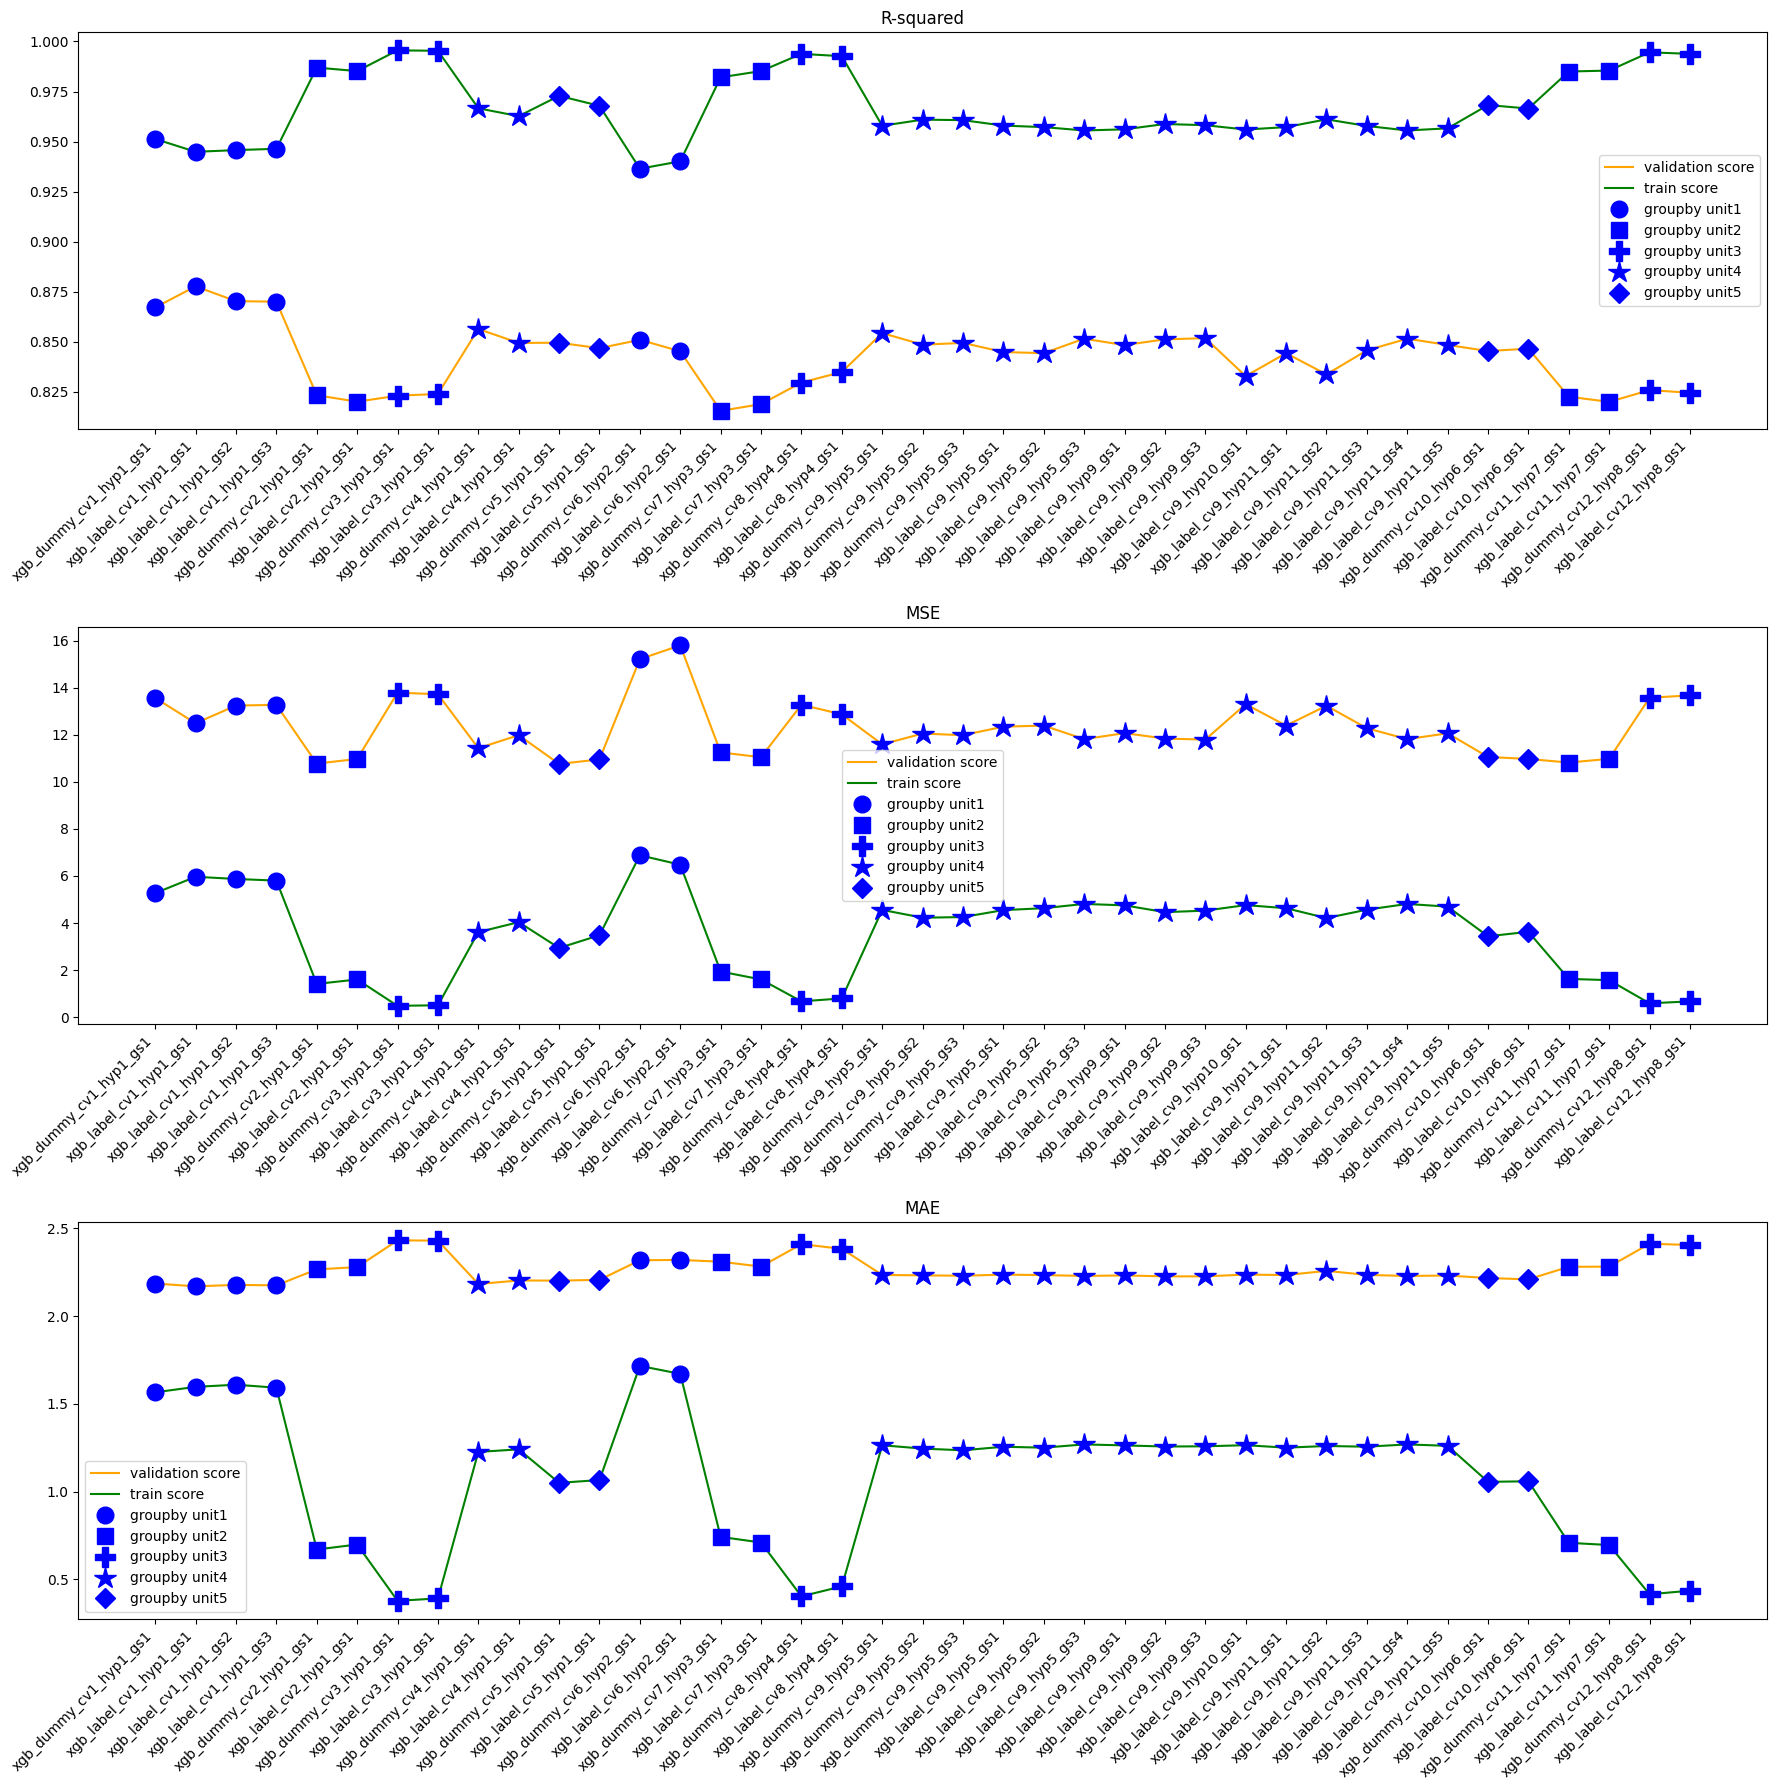

In [55]:
##############################################
#Show Validation Results
##############################################

fig, axs = plt.subplots(3, 1, figsize=(18,18))

metrics=['R-squared','MSE', 'MAE']

#plot validation scores
for metric, ax in zip(metrics, axs.ravel()):
    ax.plot(xgb_val_score['model'], xgb_val_score[metric], color='orange', label='validation score')
    ax.plot(xgb_train_score['model'], xgb_train_score[metric], color='green', label='train score')
    
    #add marker to groupby unit
    substr_list=[
        #groupby unit1
        '_cv1_|_cv6_',
        #groupby unit2
        '_cv2_|_cv7_|_cv11_',
        #groupby unit3
        '_cv3_|_cv8_|_cv12_',
        #groupby unit4
        '_cv4_|_cv9_',
        #groupby unit5
        '_cv5_|_cv10_',
    ]
    marker_list=['bo','bs','bP','b*','bD']
    markersize_list=[12,12,15,16,10]
    for substr,unit_marker, unit_marker_size, unit_index in zip(substr_list,marker_list,markersize_list,range(1,len(substr_list)+1)):
        ax.plot(xgb_val_score[xgb_val_score['model'].str.contains(substr)]['model'], xgb_val_score[xgb_val_score['model'].str.contains(substr)][metric], unit_marker,markersize=unit_marker_size,label=f"groupby unit{unit_index}")
        ax.plot(xgb_train_score[xgb_train_score['model'].str.contains(substr)]['model'], xgb_train_score[xgb_train_score['model'].str.contains(substr)][metric], unit_marker,markersize=unit_marker_size)
    ax.set_title(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()

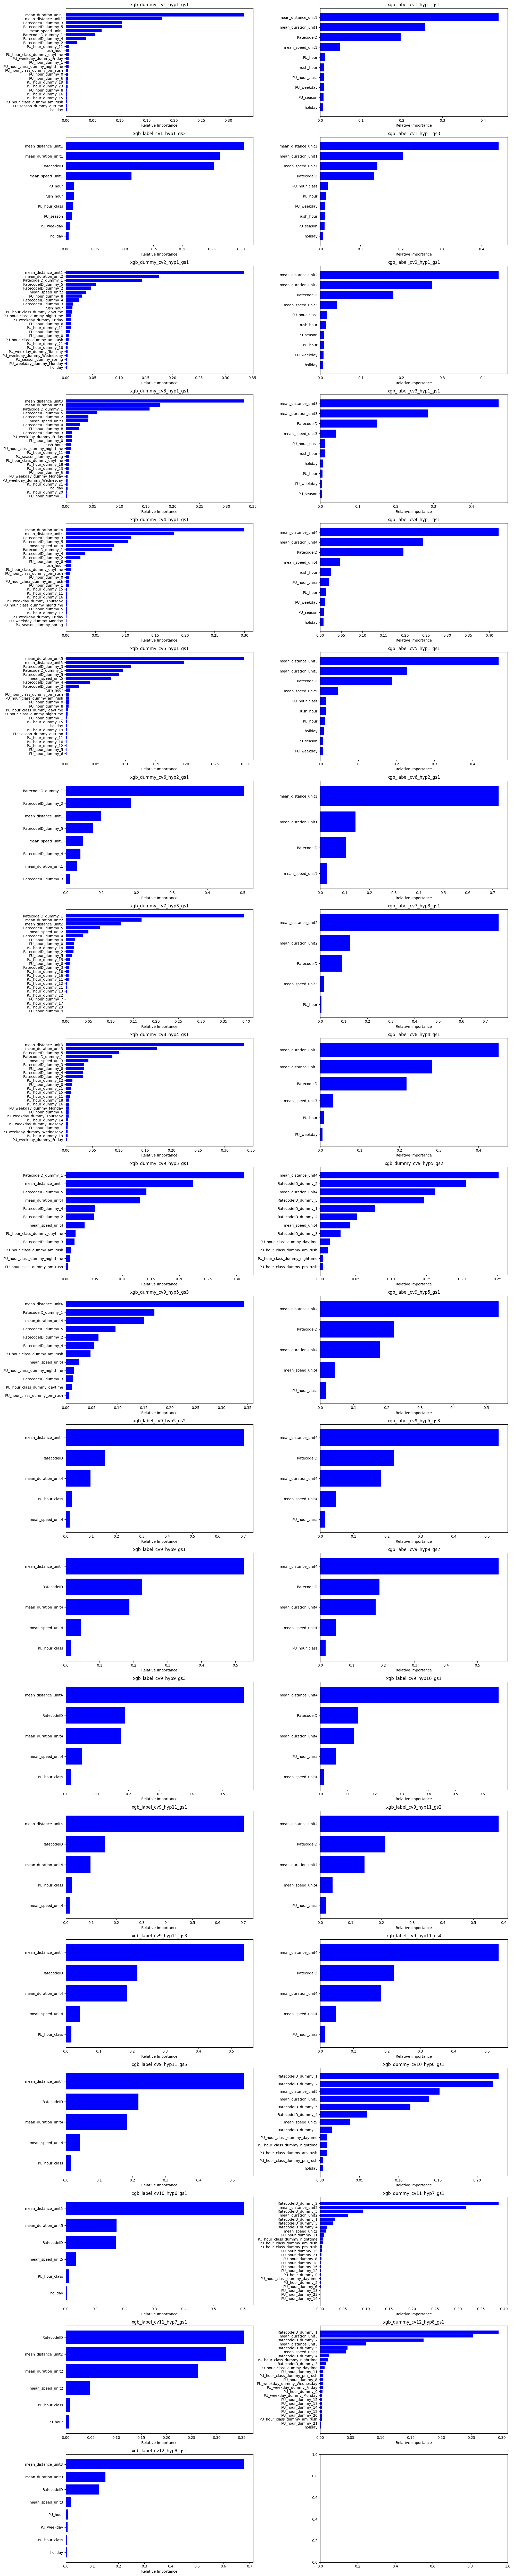

In [56]:
#############################################################
#Plot feature importance
#############################################################
import math

rowCount=math.ceil(len(xgb_cv_list)/2)
fig, axes = plt.subplots(nrows=rowCount, ncols=2, figsize=(20,rowCount*5))

for xgb_cv, ax, index in zip(xgb_cv_list, axes.flatten(), range(len(xgb_cv_list))):
    xgb_best=xgb_cv.best_estimator_
    importances = xgb_best.feature_importances_

    #pickle file xgb_[dummy|label]_cvXX_hyp*_gs* XX is index
    params_index=find_number(xgb_model_name_list[index], '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'xgb_dummy' in xgb_model_name_list[index]:
        features=get_fit_features(select_col,X_dummy_val.columns,'dummy')
    elif 'xgb_label' in xgb_model_name_list[index]:
        features=get_fit_features(select_col,X_label_val.columns,'label')

    indices = np.argsort(importances)
    # customized number
    if len(importances)>=25:
        num_features = 25
    else:
        num_features =len(importances)

    ax.set_title(xgb_model_name_list[index])
    # only plot the customized number of features
    ax.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
    ax.set_yticks(range(num_features),[features[i] for i in indices[-num_features:]])
    ax.set_xlabel('Relative Importance')

plt.tight_layout()
plt.show()

### Fit model with train and validation set

#### Calculate `mean_distance` column

In [57]:
################################################
#Use dummy encoding dataset
#use train_val dataset to compute mean
################################################
dummy_gpb_unit1=X_dummy_train_val.groupby(['gpb_unit1'])[['trip_distance']].mean()
dummy_gpb_unit2=X_dummy_train_val.groupby(['gpb_unit2'])[['trip_distance']].mean()
dummy_gpb_unit3=X_dummy_train_val.groupby(['gpb_unit3'])[['trip_distance']].mean()
dummy_gpb_unit4=X_dummy_train_val.groupby(['gpb_unit4'])[['trip_distance']].mean()
dummy_gpb_unit5=X_dummy_train_val.groupby(['gpb_unit5'])[['trip_distance']].mean()
################################################
#Use Label encoding dataset
#use train_val dataset to compute mean
################################################
label_gpb_unit1=X_label_train_val.groupby(['gpb_unit1'])[['trip_distance']].mean()
label_gpb_unit2=X_label_train_val.groupby(['gpb_unit2'])[['trip_distance']].mean()
label_gpb_unit3=X_label_train_val.groupby(['gpb_unit3'])[['trip_distance']].mean()
label_gpb_unit4=X_label_train_val.groupby(['gpb_unit4'])[['trip_distance']].mean()
label_gpb_unit5=X_label_train_val.groupby(['gpb_unit5'])[['trip_distance']].mean()

In [58]:
################################################
#Use dummy encoding dataset
#use train_val dataset to compute mean
################################################
# 1. Convert `grouped` to a dictionary
dummy_gpb_unit1_dict=dummy_gpb_unit1.to_dict()
dummy_gpb_unit2_dict=dummy_gpb_unit2.to_dict()
dummy_gpb_unit3_dict=dummy_gpb_unit3.to_dict()
dummy_gpb_unit4_dict=dummy_gpb_unit4.to_dict()
dummy_gpb_unit5_dict=dummy_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_gpb_unit1_dict=dummy_gpb_unit1_dict.get('trip_distance')
dummy_gpb_unit2_dict=dummy_gpb_unit2_dict.get('trip_distance')
dummy_gpb_unit3_dict=dummy_gpb_unit3_dict.get('trip_distance')
dummy_gpb_unit4_dict=dummy_gpb_unit4_dict.get('trip_distance')
dummy_gpb_unit5_dict=dummy_gpb_unit5_dict.get('trip_distance')

################################################
#Use Label encoding dataset
#use train_val dataset to compute mean
################################################
# 1. Convert `grouped` to a dictionary
label_gpb_unit1_dict=label_gpb_unit1.to_dict()
label_gpb_unit2_dict=label_gpb_unit2.to_dict()
label_gpb_unit3_dict=label_gpb_unit3.to_dict()
label_gpb_unit4_dict=label_gpb_unit4.to_dict()
label_gpb_unit5_dict=label_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_gpb_unit1_dict=label_gpb_unit1_dict.get('trip_distance')
label_gpb_unit2_dict=label_gpb_unit2_dict.get('trip_distance')
label_gpb_unit3_dict=label_gpb_unit3_dict.get('trip_distance')
label_gpb_unit4_dict=label_gpb_unit4_dict.get('trip_distance')
label_gpb_unit5_dict=label_gpb_unit5_dict.get('trip_distance')

In [59]:
################################################
#Use dummy encoding dataset
#train_val dataset
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_dummy_train_val['mean_distance_unit1']=X_dummy_train_val['gpb_unit1']
X_dummy_train_val['mean_distance_unit2']=X_dummy_train_val['gpb_unit2']
X_dummy_train_val['mean_distance_unit3']=X_dummy_train_val['gpb_unit3']
X_dummy_train_val['mean_distance_unit4']=X_dummy_train_val['gpb_unit4']
X_dummy_train_val['mean_distance_unit5']=X_dummy_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_dummy_train_val['mean_distance_unit1']=X_dummy_train_val['mean_distance_unit1'].map(dummy_gpb_unit1_dict)
X_dummy_train_val['mean_distance_unit2']=X_dummy_train_val['mean_distance_unit2'].map(dummy_gpb_unit2_dict)
X_dummy_train_val['mean_distance_unit3']=X_dummy_train_val['mean_distance_unit3'].map(dummy_gpb_unit3_dict)
X_dummy_train_val['mean_distance_unit4']=X_dummy_train_val['mean_distance_unit4'].map(dummy_gpb_unit4_dict)
X_dummy_train_val['mean_distance_unit5']=X_dummy_train_val['mean_distance_unit5'].map(dummy_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#train_val dataset
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_label_train_val['mean_distance_unit1']=X_label_train_val['gpb_unit1']
X_label_train_val['mean_distance_unit2']=X_label_train_val['gpb_unit2']
X_label_train_val['mean_distance_unit3']=X_label_train_val['gpb_unit3']
X_label_train_val['mean_distance_unit4']=X_label_train_val['gpb_unit4']
X_label_train_val['mean_distance_unit5']=X_label_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_label_train_val['mean_distance_unit1']=X_label_train_val['mean_distance_unit1'].map(label_gpb_unit1_dict)
X_label_train_val['mean_distance_unit2']=X_label_train_val['mean_distance_unit2'].map(label_gpb_unit2_dict)
X_label_train_val['mean_distance_unit3']=X_label_train_val['mean_distance_unit3'].map(label_gpb_unit3_dict)
X_label_train_val['mean_distance_unit4']=X_label_train_val['mean_distance_unit4'].map(label_gpb_unit4_dict)
X_label_train_val['mean_distance_unit5']=X_label_train_val['mean_distance_unit5'].map(label_gpb_unit5_dict)


In [60]:
################################################
#Use dummy encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_dummy_train_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_dummy_train_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

################################################
#Use label encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_label_train_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_label_train_val[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  16442 non-null  float64
 1   mean_distance_unit2  16442 non-null  float64
 2   mean_distance_unit3  16442 non-null  float64
 3   mean_distance_unit4  16442 non-null  float64
 4   mean_distance_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
15889,0.615362,0.3325,0.205,0.604615,0.590833
19982,1.171765,1.5500,1.300,1.225000,1.225000
10523,0.404286,0.4000,0.400,0.685000,0.685000
12043,1.270357,1.1320,1.065,1.253636,1.253636
8000,17.500000,17.2000,17.200,17.200000,17.200000


<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  16442 non-null  float64
 1   mean_distance_unit2  16442 non-null  float64
 2   mean_distance_unit3  16442 non-null  float64
 3   mean_distance_unit4  16442 non-null  float64
 4   mean_distance_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
15889,0.615362,0.3325,0.205,0.604615,0.590833
19982,1.171765,1.5500,1.300,1.225000,1.225000
10523,0.404286,0.4000,0.400,0.685000,0.685000
12043,1.270357,1.1320,1.065,1.253636,1.253636
8000,17.500000,17.2000,17.200,17.200000,17.200000


In [61]:
################################################
#Use dummy encoding dataset
#test set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_dummy_test['mean_distance_unit1']=X_dummy_test['gpb_unit1']
X_dummy_test['mean_distance_unit2']=X_dummy_test['gpb_unit2']
X_dummy_test['mean_distance_unit3']=X_dummy_test['gpb_unit3']
X_dummy_test['mean_distance_unit4']=X_dummy_test['gpb_unit4']
X_dummy_test['mean_distance_unit5']=X_dummy_test['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_dummy_test['mean_distance_unit1']=X_dummy_test['mean_distance_unit1'].map(dummy_gpb_unit1_dict)
X_dummy_test['mean_distance_unit2']=X_dummy_test['mean_distance_unit2'].map(dummy_gpb_unit2_dict)
X_dummy_test['mean_distance_unit3']=X_dummy_test['mean_distance_unit3'].map(dummy_gpb_unit3_dict)
X_dummy_test['mean_distance_unit4']=X_dummy_test['mean_distance_unit4'].map(dummy_gpb_unit4_dict)
X_dummy_test['mean_distance_unit5']=X_dummy_test['mean_distance_unit5'].map(dummy_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#test set
################################################
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
X_label_test['mean_distance_unit1']=X_label_test['gpb_unit1']
X_label_test['mean_distance_unit2']=X_label_test['gpb_unit2']
X_label_test['mean_distance_unit3']=X_label_test['gpb_unit3']
X_label_test['mean_distance_unit4']=X_label_test['gpb_unit4']
X_label_test['mean_distance_unit5']=X_label_test['gpb_unit5']
# 2. Map `grouped_dict` to the `mean_distance` column
X_label_test['mean_distance_unit1']=X_label_test['mean_distance_unit1'].map(label_gpb_unit1_dict)
X_label_test['mean_distance_unit2']=X_label_test['mean_distance_unit2'].map(label_gpb_unit2_dict)
X_label_test['mean_distance_unit3']=X_label_test['mean_distance_unit3'].map(label_gpb_unit3_dict)
X_label_test['mean_distance_unit4']=X_label_test['mean_distance_unit4'].map(label_gpb_unit4_dict)
X_label_test['mean_distance_unit5']=X_label_test['mean_distance_unit5'].map(label_gpb_unit5_dict)

In [62]:
################################################
#Use dummy encoding dataset
#test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_test.shape[0]}')
display(X_dummy_test[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_dummy_test[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

################################################
#Use label encoding dataset
#test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_test.shape[0]}')
display(X_label_test[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].info())
display(X_label_test[['mean_distance_unit1','mean_distance_unit2','mean_distance_unit3','mean_distance_unit4','mean_distance_unit5']].head())

Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  5024 non-null   float64
 1   mean_distance_unit2  2233 non-null   float64
 2   mean_distance_unit3  584 non-null    float64
 3   mean_distance_unit4  4242 non-null   float64
 4   mean_distance_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
10666,0.763243,0.93,NaN,0.707500,1.115
21791,17.357778,NaN,NaN,17.200000,17.200
11224,2.042500,2.40,NaN,2.175000,NaN
17725,0.690769,1.08,NaN,0.813333,0.876
2901,0.911250,1.40,NaN,0.900000,0.400


Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_distance_unit1  5024 non-null   float64
 1   mean_distance_unit2  2233 non-null   float64
 2   mean_distance_unit3  584 non-null    float64
 3   mean_distance_unit4  4242 non-null   float64
 4   mean_distance_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_distance_unit1,mean_distance_unit2,mean_distance_unit3,mean_distance_unit4,mean_distance_unit5
10666,0.763243,0.93,NaN,0.707500,1.115
21791,17.357778,NaN,NaN,17.200000,17.200
11224,2.042500,2.40,NaN,2.175000,NaN
17725,0.690769,1.08,NaN,0.813333,0.876
2901,0.911250,1.40,NaN,0.900000,0.400


#### Calculate `mean_duration` column

In [63]:
################################################
#Use dummy encoding dataset
#use train_val dataset to compute mean
################################################
dummy_duration_gpb_unit1=X_dummy_train_val.groupby(['gpb_unit1'])[['duration']].mean()
dummy_duration_gpb_unit2=X_dummy_train_val.groupby(['gpb_unit2'])[['duration']].mean()
dummy_duration_gpb_unit3=X_dummy_train_val.groupby(['gpb_unit3'])[['duration']].mean()
dummy_duration_gpb_unit4=X_dummy_train_val.groupby(['gpb_unit4'])[['duration']].mean()
dummy_duration_gpb_unit5=X_dummy_train_val.groupby(['gpb_unit5'])[['duration']].mean()
################################################
#Use Label encoding dataset
#use train_val dataset to compute mean
################################################
label_duration_gpb_unit1=X_label_train_val.groupby(['gpb_unit1'])[['duration']].mean()
label_duration_gpb_unit2=X_label_train_val.groupby(['gpb_unit2'])[['duration']].mean()
label_duration_gpb_unit3=X_label_train_val.groupby(['gpb_unit3'])[['duration']].mean()
label_duration_gpb_unit4=X_label_train_val.groupby(['gpb_unit4'])[['duration']].mean()
label_duration_gpb_unit5=X_label_train_val.groupby(['gpb_unit5'])[['duration']].mean()

In [64]:
################################################
#Use dummy encoding dataset
#use train_val dataset to compute mean
################################################
# 1. Convert `grouped` to a dictionary
dummy_duration_gpb_unit1_dict=dummy_duration_gpb_unit1.to_dict()
dummy_duration_gpb_unit2_dict=dummy_duration_gpb_unit2.to_dict()
dummy_duration_gpb_unit3_dict=dummy_duration_gpb_unit3.to_dict()
dummy_duration_gpb_unit4_dict=dummy_duration_gpb_unit4.to_dict()
dummy_duration_gpb_unit5_dict=dummy_duration_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_duration_gpb_unit1_dict=dummy_duration_gpb_unit1_dict.get('duration')
dummy_duration_gpb_unit2_dict=dummy_duration_gpb_unit2_dict.get('duration')
dummy_duration_gpb_unit3_dict=dummy_duration_gpb_unit3_dict.get('duration')
dummy_duration_gpb_unit4_dict=dummy_duration_gpb_unit4_dict.get('duration')
dummy_duration_gpb_unit5_dict=dummy_duration_gpb_unit5_dict.get('duration')

################################################
#Use Label encoding dataset
#use train_val dataset to compute mean
################################################
# 1. Convert `grouped` to a dictionary
label_duration_gpb_unit1_dict=label_duration_gpb_unit1.to_dict()
label_duration_gpb_unit2_dict=label_duration_gpb_unit2.to_dict()
label_duration_gpb_unit3_dict=label_duration_gpb_unit3.to_dict()
label_duration_gpb_unit4_dict=label_duration_gpb_unit4.to_dict()
label_duration_gpb_unit5_dict=label_duration_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_duration_gpb_unit1_dict=label_duration_gpb_unit1_dict.get('duration')
label_duration_gpb_unit2_dict=label_duration_gpb_unit2_dict.get('duration')
label_duration_gpb_unit3_dict=label_duration_gpb_unit3_dict.get('duration')
label_duration_gpb_unit4_dict=label_duration_gpb_unit4_dict.get('duration')
label_duration_gpb_unit5_dict=label_duration_gpb_unit5_dict.get('duration')

In [65]:
################################################
#Use dummy encoding dataset
#train_val set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_dummy_train_val['mean_duration_unit1']=X_dummy_train_val['gpb_unit1']
X_dummy_train_val['mean_duration_unit2']=X_dummy_train_val['gpb_unit2']
X_dummy_train_val['mean_duration_unit3']=X_dummy_train_val['gpb_unit3']
X_dummy_train_val['mean_duration_unit4']=X_dummy_train_val['gpb_unit4']
X_dummy_train_val['mean_duration_unit5']=X_dummy_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_dummy_train_val['mean_duration_unit1']=X_dummy_train_val['mean_duration_unit1'].map(dummy_duration_gpb_unit1_dict)
X_dummy_train_val['mean_duration_unit2']=X_dummy_train_val['mean_duration_unit2'].map(dummy_duration_gpb_unit2_dict)
X_dummy_train_val['mean_duration_unit3']=X_dummy_train_val['mean_duration_unit3'].map(dummy_duration_gpb_unit3_dict)
X_dummy_train_val['mean_duration_unit4']=X_dummy_train_val['mean_duration_unit4'].map(dummy_duration_gpb_unit4_dict)
X_dummy_train_val['mean_duration_unit5']=X_dummy_train_val['mean_duration_unit5'].map(dummy_duration_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#train_val set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_label_train_val['mean_duration_unit1']=X_label_train_val['gpb_unit1']
X_label_train_val['mean_duration_unit2']=X_label_train_val['gpb_unit2']
X_label_train_val['mean_duration_unit3']=X_label_train_val['gpb_unit3']
X_label_train_val['mean_duration_unit4']=X_label_train_val['gpb_unit4']
X_label_train_val['mean_duration_unit5']=X_label_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_label_train_val['mean_duration_unit1']=X_label_train_val['mean_duration_unit1'].map(label_duration_gpb_unit1_dict)
X_label_train_val['mean_duration_unit2']=X_label_train_val['mean_duration_unit2'].map(label_duration_gpb_unit2_dict)
X_label_train_val['mean_duration_unit3']=X_label_train_val['mean_duration_unit3'].map(label_duration_gpb_unit3_dict)
X_label_train_val['mean_duration_unit4']=X_label_train_val['mean_duration_unit4'].map(label_duration_gpb_unit4_dict)
X_label_train_val['mean_duration_unit5']=X_label_train_val['mean_duration_unit5'].map(label_duration_gpb_unit5_dict)


In [66]:
################################################
#Use dummy encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_dummy_train_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_dummy_train_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

################################################
#Use label encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_label_train_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_label_train_val[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  16442 non-null  float64
 1   mean_duration_unit2  16442 non-null  float64
 2   mean_duration_unit3  16442 non-null  float64
 3   mean_duration_unit4  16442 non-null  float64
 4   mean_duration_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
15889,4.717130,2.2875,1.0335,3.951308,3.945833
19982,12.812706,19.1000,13.8000,15.900000,15.900000
10523,2.547714,1.6170,1.6170,4.725000,4.725000
12043,7.835143,7.6568,6.7250,8.147091,8.147091
8000,42.833333,66.8000,66.8000,66.800000,66.800000


<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  16442 non-null  float64
 1   mean_duration_unit2  16442 non-null  float64
 2   mean_duration_unit3  16442 non-null  float64
 3   mean_duration_unit4  16442 non-null  float64
 4   mean_duration_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
15889,4.717130,2.2875,1.0335,3.951308,3.945833
19982,12.812706,19.1000,13.8000,15.900000,15.900000
10523,2.547714,1.6170,1.6170,4.725000,4.725000
12043,7.835143,7.6568,6.7250,8.147091,8.147091
8000,42.833333,66.8000,66.8000,66.800000,66.800000


In [67]:
################################################
#Use dummy encoding dataset
#Test set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_dummy_test['mean_duration_unit1']=X_dummy_test['gpb_unit1']
X_dummy_test['mean_duration_unit2']=X_dummy_test['gpb_unit2']
X_dummy_test['mean_duration_unit3']=X_dummy_test['gpb_unit3']
X_dummy_test['mean_duration_unit4']=X_dummy_test['gpb_unit4']
X_dummy_test['mean_duration_unit5']=X_dummy_test['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_dummy_test['mean_duration_unit1']=X_dummy_test['mean_duration_unit1'].map(dummy_duration_gpb_unit1_dict)
X_dummy_test['mean_duration_unit2']=X_dummy_test['mean_duration_unit2'].map(dummy_duration_gpb_unit2_dict)
X_dummy_test['mean_duration_unit3']=X_dummy_test['mean_duration_unit3'].map(dummy_duration_gpb_unit3_dict)
X_dummy_test['mean_duration_unit4']=X_dummy_test['mean_duration_unit4'].map(dummy_duration_gpb_unit4_dict)
X_dummy_test['mean_duration_unit5']=X_dummy_test['mean_duration_unit5'].map(dummy_duration_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#Test set
################################################
# 1. Create a duration column that is a copy of the pickup_dropoff helper column
X_label_test['mean_duration_unit1']=X_label_test['gpb_unit1']
X_label_test['mean_duration_unit2']=X_label_test['gpb_unit2']
X_label_test['mean_duration_unit3']=X_label_test['gpb_unit3']
X_label_test['mean_duration_unit4']=X_label_test['gpb_unit4']
X_label_test['mean_duration_unit5']=X_label_test['gpb_unit5']
# 2. Map `grouped_dict` to the `duration` column
X_label_test['mean_duration_unit1']=X_label_test['mean_duration_unit1'].map(label_duration_gpb_unit1_dict)
X_label_test['mean_duration_unit2']=X_label_test['mean_duration_unit2'].map(label_duration_gpb_unit2_dict)
X_label_test['mean_duration_unit3']=X_label_test['mean_duration_unit3'].map(label_duration_gpb_unit3_dict)
X_label_test['mean_duration_unit4']=X_label_test['mean_duration_unit4'].map(label_duration_gpb_unit4_dict)
X_label_test['mean_duration_unit5']=X_label_test['mean_duration_unit5'].map(label_duration_gpb_unit5_dict)


In [68]:
################################################
#Use dummy encoding dataset
#Test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_test.shape[0]}')
display(X_dummy_test[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_dummy_test[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

################################################
#Use label encoding dataset
#Test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_test.shape[0]}')
display(X_label_test[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].info())
display(X_label_test[['mean_duration_unit1','mean_duration_unit2','mean_duration_unit3','mean_duration_unit4','mean_duration_unit5']].head())

Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  5024 non-null   float64
 1   mean_duration_unit2  2233 non-null   float64
 2   mean_duration_unit3  584 non-null    float64
 3   mean_duration_unit4  4242 non-null   float64
 4   mean_duration_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
10666,5.197757,3.750,NaN,4.754000,6.7665
21791,50.531556,NaN,NaN,42.800000,42.8000
11224,12.141667,18.817,NaN,15.325000,NaN
17725,5.687192,7.733,NaN,5.616667,5.6400
2901,8.193750,13.717,NaN,8.700000,3.6830


Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_duration_unit1  5024 non-null   float64
 1   mean_duration_unit2  2233 non-null   float64
 2   mean_duration_unit3  584 non-null    float64
 3   mean_duration_unit4  4242 non-null   float64
 4   mean_duration_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_duration_unit1,mean_duration_unit2,mean_duration_unit3,mean_duration_unit4,mean_duration_unit5
10666,5.197757,3.750,NaN,4.754000,6.7665
21791,50.531556,NaN,NaN,42.800000,42.8000
11224,12.141667,18.817,NaN,15.325000,NaN
17725,5.687192,7.733,NaN,5.616667,5.6400
2901,8.193750,13.717,NaN,8.700000,3.6830


#### Calculate `mean_speed` column

In [69]:
################################################
#Use dummy encoding dataset
#Use train_val dataset
################################################
dummy_speed_gpb_unit1=X_dummy_train_val.groupby(['gpb_unit1'])[['avg_speed']].mean()
dummy_speed_gpb_unit2=X_dummy_train_val.groupby(['gpb_unit2'])[['avg_speed']].mean()
dummy_speed_gpb_unit3=X_dummy_train_val.groupby(['gpb_unit3'])[['avg_speed']].mean()
dummy_speed_gpb_unit4=X_dummy_train_val.groupby(['gpb_unit4'])[['avg_speed']].mean()
dummy_speed_gpb_unit5=X_dummy_train_val.groupby(['gpb_unit5'])[['avg_speed']].mean()
################################################
#Use Label encoding dataset
#Use train_val dataset
################################################
label_speed_gpb_unit1=X_label_train_val.groupby(['gpb_unit1'])[['avg_speed']].mean()
label_speed_gpb_unit2=X_label_train_val.groupby(['gpb_unit2'])[['avg_speed']].mean()
label_speed_gpb_unit3=X_label_train_val.groupby(['gpb_unit3'])[['avg_speed']].mean()
label_speed_gpb_unit4=X_label_train_val.groupby(['gpb_unit4'])[['avg_speed']].mean()
label_speed_gpb_unit5=X_label_train_val.groupby(['gpb_unit5'])[['avg_speed']].mean()

In [70]:
################################################
#Use dummy encoding dataset
#Use train_val dataset
################################################
# 1. Convert `grouped` to a dictionary
dummy_speed_gpb_unit1_dict=dummy_speed_gpb_unit1.to_dict()
dummy_speed_gpb_unit2_dict=dummy_speed_gpb_unit2.to_dict()
dummy_speed_gpb_unit3_dict=dummy_speed_gpb_unit3.to_dict()
dummy_speed_gpb_unit4_dict=dummy_speed_gpb_unit4.to_dict()
dummy_speed_gpb_unit5_dict=dummy_speed_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
dummy_speed_gpb_unit1_dict=dummy_speed_gpb_unit1_dict.get('avg_speed')
dummy_speed_gpb_unit2_dict=dummy_speed_gpb_unit2_dict.get('avg_speed')
dummy_speed_gpb_unit3_dict=dummy_speed_gpb_unit3_dict.get('avg_speed')
dummy_speed_gpb_unit4_dict=dummy_speed_gpb_unit4_dict.get('avg_speed')
dummy_speed_gpb_unit5_dict=dummy_speed_gpb_unit5_dict.get('avg_speed')

################################################
#Use Label encoding dataset
#Use train_val dataset
################################################
# 1. Convert `grouped` to a dictionary
label_speed_gpb_unit1_dict=label_speed_gpb_unit1.to_dict()
label_speed_gpb_unit2_dict=label_speed_gpb_unit2.to_dict()
label_speed_gpb_unit3_dict=label_speed_gpb_unit3.to_dict()
label_speed_gpb_unit4_dict=label_speed_gpb_unit4.to_dict()
label_speed_gpb_unit5_dict=label_speed_gpb_unit5.to_dict()
# 2. Reassign to only contain the inner dictionary
label_speed_gpb_unit1_dict=label_speed_gpb_unit1_dict.get('avg_speed')
label_speed_gpb_unit2_dict=label_speed_gpb_unit2_dict.get('avg_speed')
label_speed_gpb_unit3_dict=label_speed_gpb_unit3_dict.get('avg_speed')
label_speed_gpb_unit4_dict=label_speed_gpb_unit4_dict.get('avg_speed')
label_speed_gpb_unit5_dict=label_speed_gpb_unit5_dict.get('avg_speed')

In [71]:
################################################
#Use dummy encoding dataset
#train_val set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_dummy_train_val['mean_speed_unit1']=X_dummy_train_val['gpb_unit1']
X_dummy_train_val['mean_speed_unit2']=X_dummy_train_val['gpb_unit2']
X_dummy_train_val['mean_speed_unit3']=X_dummy_train_val['gpb_unit3']
X_dummy_train_val['mean_speed_unit4']=X_dummy_train_val['gpb_unit4']
X_dummy_train_val['mean_speed_unit5']=X_dummy_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_dummy_train_val['mean_speed_unit1']=X_dummy_train_val['mean_speed_unit1'].map(dummy_speed_gpb_unit1_dict)
X_dummy_train_val['mean_speed_unit2']=X_dummy_train_val['mean_speed_unit2'].map(dummy_speed_gpb_unit2_dict)
X_dummy_train_val['mean_speed_unit3']=X_dummy_train_val['mean_speed_unit3'].map(dummy_speed_gpb_unit3_dict)
X_dummy_train_val['mean_speed_unit4']=X_dummy_train_val['mean_speed_unit4'].map(dummy_speed_gpb_unit4_dict)
X_dummy_train_val['mean_speed_unit5']=X_dummy_train_val['mean_speed_unit5'].map(dummy_speed_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#train_val set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_label_train_val['mean_speed_unit1']=X_label_train_val['gpb_unit1']
X_label_train_val['mean_speed_unit2']=X_label_train_val['gpb_unit2']
X_label_train_val['mean_speed_unit3']=X_label_train_val['gpb_unit3']
X_label_train_val['mean_speed_unit4']=X_label_train_val['gpb_unit4']
X_label_train_val['mean_speed_unit5']=X_label_train_val['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_label_train_val['mean_speed_unit1']=X_label_train_val['mean_speed_unit1'].map(label_speed_gpb_unit1_dict)
X_label_train_val['mean_speed_unit2']=X_label_train_val['mean_speed_unit2'].map(label_speed_gpb_unit2_dict)
X_label_train_val['mean_speed_unit3']=X_label_train_val['mean_speed_unit3'].map(label_speed_gpb_unit3_dict)
X_label_train_val['mean_speed_unit4']=X_label_train_val['mean_speed_unit4'].map(label_speed_gpb_unit4_dict)
X_label_train_val['mean_speed_unit5']=X_label_train_val['mean_speed_unit5'].map(label_speed_gpb_unit5_dict)


In [72]:
################################################
#Use dummy encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_dummy_train_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_dummy_train_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

################################################
#Use label encoding dataset
#train_val set
################################################
# Confirm that it worked
display(X_label_train_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_label_train_val[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  16442 non-null  float64
 1   mean_speed_unit2  16442 non-null  float64
 2   mean_speed_unit3  16442 non-null  float64
 3   mean_speed_unit4  16442 non-null  float64
 4   mean_speed_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
15889,8.703269,10.576850,13.374545,10.061870,9.941853
19982,6.880921,5.039202,5.652174,5.283078,5.283078
10523,9.551851,14.845361,14.845361,11.137574,11.137574
12043,10.116530,8.905063,9.446919,9.364158,9.364158
8000,28.307119,15.449102,15.449102,15.449102,15.449102


<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 15889 to 2732
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  16442 non-null  float64
 1   mean_speed_unit2  16442 non-null  float64
 2   mean_speed_unit3  16442 non-null  float64
 3   mean_speed_unit4  16442 non-null  float64
 4   mean_speed_unit5  16442 non-null  float64
dtypes: float64(5)
memory usage: 770.7 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
15889,8.703269,10.576850,13.374545,10.061870,9.941853
19982,6.880921,5.039202,5.652174,5.283078,5.283078
10523,9.551851,14.845361,14.845361,11.137574,11.137574
12043,10.116530,8.905063,9.446919,9.364158,9.364158
8000,28.307119,15.449102,15.449102,15.449102,15.449102


In [73]:
################################################
#Use dummy encoding dataset
#Test set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_dummy_test['mean_speed_unit1']=X_dummy_test['gpb_unit1']
X_dummy_test['mean_speed_unit2']=X_dummy_test['gpb_unit2']
X_dummy_test['mean_speed_unit3']=X_dummy_test['gpb_unit3']
X_dummy_test['mean_speed_unit4']=X_dummy_test['gpb_unit4']
X_dummy_test['mean_speed_unit5']=X_dummy_test['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_dummy_test['mean_speed_unit1']=X_dummy_test['mean_speed_unit1'].map(dummy_speed_gpb_unit1_dict)
X_dummy_test['mean_speed_unit2']=X_dummy_test['mean_speed_unit2'].map(dummy_speed_gpb_unit2_dict)
X_dummy_test['mean_speed_unit3']=X_dummy_test['mean_speed_unit3'].map(dummy_speed_gpb_unit3_dict)
X_dummy_test['mean_speed_unit4']=X_dummy_test['mean_speed_unit4'].map(dummy_speed_gpb_unit4_dict)
X_dummy_test['mean_speed_unit5']=X_dummy_test['mean_speed_unit5'].map(dummy_speed_gpb_unit5_dict)

################################################
#Use Label encoding dataset
#Test set
################################################
# 1. Create a speed column that is a copy of the pickup_dropoff helper column
X_label_test['mean_speed_unit1']=X_label_test['gpb_unit1']
X_label_test['mean_speed_unit2']=X_label_test['gpb_unit2']
X_label_test['mean_speed_unit3']=X_label_test['gpb_unit3']
X_label_test['mean_speed_unit4']=X_label_test['gpb_unit4']
X_label_test['mean_speed_unit5']=X_label_test['gpb_unit5']
# 2. Map `grouped_dict` to the `speed` column
X_label_test['mean_speed_unit1']=X_label_test['mean_speed_unit1'].map(label_speed_gpb_unit1_dict)
X_label_test['mean_speed_unit2']=X_label_test['mean_speed_unit2'].map(label_speed_gpb_unit2_dict)
X_label_test['mean_speed_unit3']=X_label_test['mean_speed_unit3'].map(label_speed_gpb_unit3_dict)
X_label_test['mean_speed_unit4']=X_label_test['mean_speed_unit4'].map(label_speed_gpb_unit4_dict)
X_label_test['mean_speed_unit5']=X_label_test['mean_speed_unit5'].map(label_speed_gpb_unit5_dict)



In [74]:
################################################
#Use dummy encoding dataset
#Test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_dummy_test.shape[0]}')
display(X_dummy_test[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_dummy_test[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

################################################
#Use label encoding dataset
#Test set
################################################
# Confirm that it worked
print(f'Validation set count: {X_label_test.shape[0]}')
display(X_label_test[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].info())
display(X_label_test[['mean_speed_unit1','mean_speed_unit2','mean_speed_unit3','mean_speed_unit4','mean_speed_unit5']].head())

Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  5024 non-null   float64
 1   mean_speed_unit2  2233 non-null   float64
 2   mean_speed_unit3  584 non-null    float64
 3   mean_speed_unit4  4242 non-null   float64
 4   mean_speed_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
10666,10.236920,14.880000,NaN,9.186092,11.426371
21791,22.054624,NaN,NaN,24.112150,24.112150
11224,10.659210,7.652790,NaN,8.770057,NaN
17725,8.268435,8.379310,NaN,9.437054,10.233555
2901,7.853797,6.123937,NaN,6.319887,6.515837


Validation set count: 5481
<class 'pandas.core.frame.DataFrame'>
Index: 5481 entries, 10666 to 15599
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_speed_unit1  5024 non-null   float64
 1   mean_speed_unit2  2233 non-null   float64
 2   mean_speed_unit3  584 non-null    float64
 3   mean_speed_unit4  4242 non-null   float64
 4   mean_speed_unit5  3527 non-null   float64
dtypes: float64(5)
memory usage: 256.9 KB


None

,mean_speed_unit1,mean_speed_unit2,mean_speed_unit3,mean_speed_unit4,mean_speed_unit5
10666,10.236920,14.880000,NaN,9.186092,11.426371
21791,22.054624,NaN,NaN,24.112150,24.112150
11224,10.659210,7.652790,NaN,8.770057,NaN
17725,8.268435,8.379310,NaN,9.437054,10.233555
2901,7.853797,6.123937,NaN,6.319887,6.515837


#### Fit train+validation set with best hyperpatameters

In [75]:
#Use use random forest model, 
#just want to see difference on validation set score and test set score

#get best params
best_model_index=xgb_model_name_list.index('xgb_label_cv9_hyp11_gs4')
best_xgb=xgb_cv_list[best_model_index]
best_params=best_xgb.best_params_
best_params.pop('xgb Model name')
best_model_name=xgb_model_name_list[best_model_index]
#pickle file xgb_[dummy|label]_cvXX_hyp*_gs* XX is index
params_index=find_number(best_model_name, '_cv')[0]-1
select_col=select_col_list[params_index].copy()
print(f"best hyperpatameters: {best_params}")
print(f"best features: {select_col}")
print(f"best model name: {best_model_name}")

best hyperpatameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.3}
best features: ['mean_distance_unit4', 'mean_duration_unit4', 'mean_speed_unit4', 'PU_hour_class', 'RatecodeID']
best model name: xgb_label_cv9_hyp11_gs4


In [76]:
###################################################
#Fit model
###################################################
xgb_regressor_best = XGBRegressor(**best_params,
                                          random_state=RANDOM_STATE)
best_xgb
if 'xgb_dummy' in best_model_name:
    select_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
    # Fiting the model to the training data using the best parameters
    xgb_regressor_best.fit(X_dummy_train_val[select_feature], y_dummy_train_val)
        
elif 'xgb_label' in best_model_name:
    select_feature=get_fit_features(select_col,X_label_train.columns,'label')
    # Fiting the model to the training data using the best parameters
    xgb_regressor_best.fit(X_label_train_val[select_feature], y_label_train_val)

### Test on test set

In [77]:
###################################################
#Test Results
###################################################
if 'xgb_dummy' in best_model_name:
    select_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
    num_params=len(select_feature)
    #drop na in validation or test set
    X_test=X_dummy_test[select_feature].copy()
    X_test=X_test.dropna()
    y_test=y_dummy_test.loc[X_test.index]
    xgb_preds=xgb_regressor_best.predict(X_test[select_feature])
    test_score=get_regression_scores(best_model_name, xgb_preds, y_test,num_params)
        
elif 'xgb_label' in best_model_name:
    select_feature=get_fit_features(select_col,X_label_train.columns,'label')
    num_params=len(select_feature)
    #drop na in validation or test set
    X_test=X_label_test[select_feature].copy()
    X_test=X_test.dropna()
    y_test=y_label_test.loc[X_test.index]
    xgb_preds=xgb_regressor_best.predict(X_test[select_feature])
    test_score=get_regression_scores(best_model_name, xgb_preds, y_test,num_params)

xgb_test_score=pd.concat([test_score]).reset_index(drop=True)
xgb_test_score.to_csv('xgb_test_score.csv', index=False)
xgb_test_score

,model,R-squared,Adjusted R-squared,MSE,MAE,AIC,BIC
0,xgb_label_cv9_hyp11_gs4,0.839915,0.839764,13.262072,2.258988,23013.455088,23045.219039


In [78]:
###################################################
#Just see all models
###################################################
xgb_all_test_score_list=[]
for xgb_cv, index in zip(xgb_cv_list, range(len(xgb_cv_list))):
    xgb_params=xgb_cv.best_params_
    if 'xgb Model name' in xgb_params:
        xgb_params.pop('xgb Model name')
    xgb_regressor = XGBRegressor(**xgb_params,
                                 random_state=RANDOM_STATE)
    #pickle file xgb_[dummy|label]_cvXX_hyp*_gs* XX is index
    params_index=find_number(xgb_model_name_list[index], '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'xgb_dummy' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_dummy_train.columns,'dummy')
        num_params=len(select_feature)
        # Fiting the model to the training data using the best parameters
        xgb_regressor.fit(X_dummy_train_val[select_feature], y_dummy_train_val)
        
        #drop na in testidation or test set
        X_test=X_dummy_test[select_feature].copy()
        X_test=X_test.dropna()
        y_test=y_dummy_test.loc[X_test.index]
        xgb_preds=xgb_regressor.predict(X_test[select_feature])
        test_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_test,num_params)
        
    elif 'xgb_label' in xgb_model_name_list[index]:
        select_feature=get_fit_features(select_col,X_label_train.columns,'label')
        num_params=len(select_feature)
        # Fiting the model to the training data using the best parameters
        xgb_regressor.fit(X_label_train_val[select_feature], y_label_train_val)
        
        #drop na in testidation or test set
        X_test=X_label_test[select_feature].copy()
        X_test=X_test.dropna()
        y_test=y_label_test.loc[X_test.index]
        xgb_preds=xgb_regressor.predict(X_test[select_feature])
        test_score=get_regression_scores(xgb_model_name_list[index], xgb_preds, y_test,num_params)
    
    xgb_all_test_score_list.append(test_score)

xgb_all_test_score=pd.concat(xgb_all_test_score_list).reset_index(drop=True)
xgb_all_test_score.to_csv('xgb_all_test_score.csv', index=False)
xgb_all_test_score

,model,R-squared,Adjusted R-squared,MSE,MAE,AIC,BIC
0,xgb_dummy_cv1_hyp1_gs1,0.884666,0.883554,11.151006,2.132885,26471.019524,26790.596627
1,xgb_label_cv1_hyp1_gs1,0.886430,0.886226,10.980473,2.129854,26315.593896,26380.813713
2,xgb_label_cv1_hyp1_gs2,0.880329,0.880115,11.570336,2.146304,26578.479991,26643.699808
3,xgb_label_cv1_hyp1_gs3,0.887857,0.887656,10.842510,2.118329,26252.070277,26317.290094
4,xgb_dummy_cv2_hyp1_gs1,0.778603,0.773737,13.716465,2.322173,12282.306481,12562.150442
5,xgb_label_cv2_hyp1_gs1,0.778471,0.777574,13.724611,2.324847,12205.632220,12262.743233
6,xgb_dummy_cv3_hyp1_gs1,0.813775,0.797067,11.974114,2.370697,3205.244550,3419.369698
7,xgb_label_cv3_hyp1_gs1,0.808931,0.805935,12.285617,2.385546,3142.242895,3185.941905
8,xgb_dummy_cv4_hyp1_gs1,0.847215,0.845466,12.657307,2.211324,22903.466008,23214.752725
9,xgb_label_cv4_hyp1_gs1,0.847357,0.847033,12.645537,2.225085,22821.519429,22885.047330
